In [1]:
#!pip install biopython
import sys, os, copy, pprint, glob
import datetime, json
#import pathlib
import matplotlib.pyplot as plt

from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np

from Bio import SeqIO
import BLAST.BlastRun as BlastRun
import BLAST.seq_interval as seq_interval
import utils.IO as IO
import utils.MolBio as MB
from Bio import Align
from PIL import Image

IO.py


In [196]:
#Set Work directory:
ud="/tdata1/betacoronavirus/"
seq_ud=ud+'seqs/'
genomic_fn='coronarefseq_NC_045512.fa'
gene_fn='coronarefseq_NC_045512.txt'
genbank_fn='NC_045512_.gb'
gisaid_fn='gisaid_cov2020_sequences_20200416.fasta'

In [197]:
tc=IO.TimeCode()
print(tc)

20200416T1511


In [169]:
class Genbank_Record:
    def __init__(self, record):
        self.gb=record
        self.gene_dict =dict((feat.qualifiers['gene'][0], feat) for feat in list(filter(lambda x:x.type=='CDS', self.gb.features)))
        self.Acc=self.gb.id
        self.seq=self.gb.seq
    def seq(self, gene_name=''):
        if not(gene_name):
            return self.seq.encode().decode()
        else:
            s=(self.gene_dict[gene_name].extract(self.seq))
            return s.encode().decode()
    def to_fasta(self, feature):
        gene_name=feature.qualifiers['gene'][0]
        s=feature.extract(self.seq)
        seq=s.encode().decode()
        #feature.location.start.position, feature.location.end.position,
        fa_label='%s|%s|%s|'%(self.gb.id, gene_name, str(feature.location))
        return [fa_label, seq]
    def iter_features(self):
        lst=list(self.gene_dict.values())
        lst.sort(key=lambda x:x.location.start.position)
        for feat in lst:
            yield feat
        
def load_genbank(gb_path):
    lst=[]
    with open(gb_path, "r") as input_handle:
        for record in SeqIO.parse(input_handle, "genbank"):
            lst.append(Genbank_Record(record))
    return lst

In [170]:
l=load_genbank(seq_ud+genbank_fn)
r=l[0]
for f in r.iter_features():
    print(f.location.start.position, str(r.to_fasta(f))[:100])

265 ['NC_045512.2|ORF1ab|[265:13483](+)|', 'ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTT
21562 ['NC_045512.2|S|[21562:25384](+)|', 'ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGA
25392 ['NC_045512.2|ORF3a|[25392:26220](+)|', 'ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAAT
26244 ['NC_045512.2|E|[26244:26472](+)|', 'ATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTT
26522 ['NC_045512.2|M|[26522:27191](+)|', 'ATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAAC
27201 ['NC_045512.2|ORF6|[27201:27387](+)|', 'ATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGG
27393 ['NC_045512.2|ORF7a|[27393:27759](+)|', 'ATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTA
27755 ['NC_045512.2|ORF7b|[27755:27887](+)|', 'ATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCT
27893 ['NC_045512.2|ORF8|[27893:28259](+)|', 'ATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGT
28273 ['NC_045512.2|N|[28273:29533](+)|

In [67]:
f.location.start.position

29557

## Cleanup Sequences for BLAST

In [198]:
#Cleanup
gisaid_fn='gisaid_cov2020_sequences_20200416.fasta'
ofp=open(seq_ud+'f'+gisaid_fn, 'w')
idx=0
for q_rec in SeqIO.parse(seq_ud+gisaid_fn, "fasta"):
    print(idx, q_rec.id, end='\r')
    label=q_rec.name.replace('\n', '').strip()
    seq=q_rec.seq.__str__().replace('-','').replace(' ','')
    ofp.write('>%s\n%s\n'%(label, seq))
    idx+=1
    
# subj_pth=seq_ud+'s.fa'
# query_pth=seq_ud+'q.fa'

# SeqIO.write(r.gb, subj_pth, "fasta")
# SeqIO.write(q_rec, query_pth, "fasta")


## Run Blast

In [199]:
def runBlast(query_path, seq_ud, bo_path='', subj_pth='', fdb_path=''):
    if not(bo_path):
        bo_path=seq_ud+'bo_generic.json'
    subj_FDB = BlastRun.FormatDB(subj_pth, fdb_path, input_type='fasta', dbtype = 'nucl', title = "")
    if not(subj_FDB.AlreadyExists()):
        subj_FDB.RunFromFDB(parse_seqids=False)
    
    blast_params={
                      'dust':"no",
                      'outfmt':15,
                      'num_threads':15,
                      'word_size':7,
                      'max_target_seqs': 100000
                      }
    BR=BlastRun.BlastRunObj(query_path, bo_path, fdb_path, blast_params=blast_params)
    BR.make_cmd()
    print(BR.cmd)
    return BR.RunBlast()

query_path=seq_ud+gisaid_fn
fdb_path=seq_ud+'refseq_covid19'

runBlast(query_path, seq_ud,  bo_path='', subj_pth='', fdb_path=fdb_path)

cmdstr: blastdbcmd -db /tdata1/betacoronavirus/seqs/refseq_covid19 -entry all -outfmt "%t %l"|tee /tdata1/betacoronavirus/seqs/SLST.TXT
ListBlastDB: returning 1 recs
cmdstr: blastdbcmd -db /tdata1/betacoronavirus/seqs/refseq_covid19 -entry all -outfmt "%t %l"|tee /tdata1/betacoronavirus/seqs/SLST.TXT
ListBlastDB: returning 1 recs
FormatDB::AlreadyExists: /tdata1/betacoronavirus/seqs/refseq_covid19.nsq  exists: True
blastn  -query /tdata1/betacoronavirus/seqs/gisaid_cov2020_sequences_20200416.fasta -out /tdata1/betacoronavirus/seqs/bo_generic.json -db /tdata1/betacoronavirus/seqs/refseq_covid19 -dust no -outfmt 15 -num_threads 15 -word_size 7 -max_target_seqs 100000;


'/tdata1/betacoronavirus/seqs/bo_generic.json'

In [200]:
class HSP(seqInterval):
    def __init__(self, hsp):
        self.qseq= hsp['qseq']
        self.hseq= hsp['hseq']
        self.matchline= hsp['midline']
        self.n=len(self.matchline)
        self.score=hsp['score']
        self.align_len=hsp['align_len']
        self.similarity_score=hsp['identity']/float(hsp['align_len'])
        self.query_start=int(hsp['query_from'])
        self.query_to=int(hsp['query_to'])
        self.query_strand=hsp['query_strand']
        self.subj_start=int(hsp['hit_from'])
        self.subj_to=int(hsp['hit_to'])
        self.subj_strand=hsp['hit_strand']
        self.same_strand=self.query_strand==self.subj_strand
        seqInterval.__init__(self, self.subj_start,self.subj_to,'subj_blast', key_block_size=100000)
        self.mismatch_dict=self.make_mm_dict(hsp)
    def make_mm_dict(self, hsp):
        d={}
        if (not(self.same_strand) or self.subj_start>self.subj_to):
            self.antisense()
            #raise Exception('spam', 'eggs')
        pos=self.subj_start
        for i in range(self.n):
            #ToDo This is a Hack and needs to be fixed for Inserts
            pos+=1
            if self.hseq[i]=='-':
                d[pos]='I%s'%self.qseq[i]
                continue
            elif self.matchline[i]==' ':
                d[pos]='%s>%s'%(self.hseq[i], self.qseq[i])
        return d
    def antisense(self):
        #print('Antisense')
        self.matchline=MB.StrReverse(self.matchline)
        self.query_strand=MB.Antisense(self.query_strand)
        self.subj_strand=MB.Antisense(self.subj_strand)
        s=self.subj_start
        self.subj_start=self.subj_to
        self.subj_to=s
        s=self.query_start
        self.query_start=self.query_to
        self.query_to=s
    def display(self, delta=25):
        for i in range(0, self.n, delta):
            if not(' ' in self.matchline[i:i+delta]):continue#skips uninformative alignments
            print(self.hseq[i:i+delta], self.subj_start+i+delta)
            print(self.matchline[i:i+delta])
            print(self.qseq[i:i+delta], self.query_start+i+delta)
            print()

class Hit:
    def __init__(self, hit):
        self.query_name=hit['description'][0]['title']
        self.subj_label=hit['description'][0]['title']
        self.subj_acc=hit['description'][0]['accession']
        self.query_len=hit['query_len']
        self.num_hsp=len(hit['hsps'])
        self.hit_id=hit['num']
        self.match_dict={}
        self.hspLst=[]
        self.align_len=0
        #assumes hsp order is from best to worst
        for hsp in hit['hsps'][:1]:##ToDo: FIX!! This is a HACK!!!
            H=HSP(hsp);use_hsp=True
            for phsp in self.hspLst:
                if phsp.intersect(H):
                    use_hsp=False
            if use_hsp:
                self.hspLst.append(H)
        print('num_hsps', len(hit['hsps']), 'accepted:', len(self.hspLst))
        similarity=0.0
        for hsp in self.hspLst:
            self.match_dict.update(hsp.mismatch_dict)
            self.align_len+=hsp.align_len
            similarity+=(hsp.similarity_score*hsp.align_len)
        self.hsp_similarity=similarity/self.align_len
        self.query_similarity=self.align_len/self.query_len*self.hsp_similarity
    def display(self):
        print(self.query_name, self.num_hsp, self.align_len, self.query_len, self.hsp_similarity, self.query_similarity)
        
        

def OLDrun_parse_blast(seq_ud, bo_path):
    bo_json=json.loads(open(bo_path).read())
    d={}
    for bb in bo_json["BlastOutput2"]:
        report=bb["report"]
        query_label=report['results']["search"]["query_title"]
        for hit in report['results']["search"]["hits"]:
            h=Hit(hit)
            d=h.mm_dict()
            if None:
                h.display()
                for k, v in d.items():
                    p=k-h.subj_start
                    print(k, v, h.hseq[p], h.hseq[p-1:p+2])
            break
    return d

def run_parse_blast(bo_json):
    d={}
    report=bo_json["report"]
    query_label=report['results']["search"]["query_title"]
    query_len=report['results']["search"]["query_len"]
    for hit in report['results']["search"]["hits"]:
        hit['query_len']=query_len
        hit_obj=Hit(hit)
        if hit_obj.align_len>300:
            d.update(hit_obj.match_dict)
    return query_label, d
    

In [201]:
def find_start_end(bo_path, read_size=1000000):
    """Used to test json blast outputs output option 15"""
    find_startpoint = lambda b, p: b.find("\n{\n", p+1)
    find_endpoint = lambda b, p: b.find("\n  }\n", p+1)
    fp=open(bo_path, 'r')
    file_sz=os.path.getsize(bo_path)
    #find"\n{\n" and tail with " }\n"}
    b=' ';pos=0;slst=[];elst=[]
    buffer_start_pos=fp.tell()
    find_start=True
    while buffer_start_pos < file_sz:
        buffer_start_pos=fp.tell()
        print('fp:', buffer_start_pos, 'find_start', find_start)
        b=fp.read(read_size)
        p=1
        while p>0:
            p=find_startpoint(b,p)
            if p>0:
                slst.append(p)
        p=1
        while p>0:
            p=find_endpoint(b,p)
            if p>0:
                elst.append(p)
    return slst, elst
        
def iter_blast_out_json(bo_path, read_size=1000000):
    """Used to iterate over large json blast outputs output option 15"""
    find_startpoint = lambda b, p: b.find("\n{\n", p+1)
    find_endpoint = lambda b, p: b.find("\n  }\n", p+1)
    
    fp=open(bo_path, 'r')
    file_sz=os.path.getsize(bo_path)
    #find"\n{\n" and tail with " }\n"}
    b=' ';pos=0;lst=[]
    start_point=end_point=-1
    buffer_start_pos=fp.tell()
    find_start=True
    idx=0
    while buffer_start_pos < file_sz:
        buffer_start_pos=fp.tell()
        #print('fp:', buffer_start_pos, 'find_start', find_start)
        b=fp.read(read_size)
        current_fpos=fp.tell()
        p=1
        while p>0:
            if find_start:
                p=find_startpoint(b, p)
                if p>0:
                    start_point=buffer_start_pos+p
                    #print('found start', start_point)
                    find_start=False
            else:
                p=find_endpoint(b, p)
                if p>0:
                    end_point=buffer_start_pos+p
                    #print('found end', end_point)
                    print('\n', idx, 'found start, end', start_point, end_point, end_point-start_point)
                    idx+=1
                    lst.append([start_point, end_point+4])
                    s,e=lst[-1]
                    fp.seek(s)
                    yield json.loads(fp.read(e-s))
                    
                    fp.seek(current_fpos)
                    find_start=True
    if None:
        print(lst)
        for p in lst:
            s,e=p
            fp.seek(s)
            print(s, 'start_>%s<'%fp.read(20))
            fp.seek(e)
            print(e, 'end_>%s<'%fp.read(20))
    fp.close()

bo_path=ud+'seqs/bo_gsaid_8k.json'#bo_primer_corona.txt'#
print(os.path.getsize(bo_path))
jLst=[]
mut_dict={};idx=0
for x in iter_blast_out_json(bo_path):
    query_label, d=run_parse_blast(x)
    k='%i_%s'%(idx, query_label)
    print(k, len(d))
    mut_dict[k]=d
    idx+=1
    jLst.append(x)
    if None:
        s=str(x)
        print(s[:20], '\n', s[-20:])
    
#find_start_end(bo_path, read_size=1000000)

1055511801

 0 found start, end 19 132290 132271
num_hsps 63 accepted: 1
0_hCoV-19/USA/WA-S88/2020|EPI_ISL_417141|2020-03-01 5

 1 found start, end 132296 264611 132315
num_hsps 63 accepted: 1
1_hCoV-19/USA/NY_2929/2020|EPI_ISL_420793|2020-03-02 6

 2 found start, end 264617 396860 132243
num_hsps 63 accepted: 1
2_hCoV-19/USA/WA-S89/2020|EPI_ISL_417142|2020-02-29 7

 3 found start, end 396866 529181 132315
num_hsps 63 accepted: 1
3_hCoV-19/USA/NH_0008/2020|EPI_ISL_420792|2020-03-02 8

 4 found start, end 529187 661502 132315
num_hsps 63 accepted: 1
4_hCoV-19/USA/RI_0556/2020|EPI_ISL_420795|2020-03-01 6

 5 found start, end 661508 793782 132274
num_hsps 63 accepted: 1
5_hCoV-19/USA/WA-S87/2020|EPI_ISL_417140|2020-03-01 6

 6 found start, end 793788 926103 132315
num_hsps 63 accepted: 1
6_hCoV-19/USA/OR_5430/2020|EPI_ISL_420794|2020-03-01 3

 7 found start, end 926109 1058380 132271
num_hsps 63 accepted: 1
7_hCoV-19/USA/WA-S92/2020|EPI_ISL_417145|2020-02-29 5

 8 found start, end 1058386

num_hsps 64 accepted: 1
86_hCoV-19/Hong 16

 87 found start, end 11522989 11652773 129784
num_hsps 64 accepted: 1
87_hCoV-19/Hong 20

 88 found start, end 11652779 11785046 132267
num_hsps 63 accepted: 1
88_hCoV-19/USA/WA-S117/2020|EPI_ISL_417170|2020-03-02 5

 89 found start, end 11785052 11917325 132273
num_hsps 63 accepted: 1
89_hCoV-19/USA/WA-S118/2020|EPI_ISL_417171|2020-03-01 5

 90 found start, end 11917331 12048839 131508
num_hsps 64 accepted: 1
90_hCoV-19/Australia/NSW14/2020|EPI_ISL_413600|2020-03-03 5

 91 found start, end 12048845 12181708 132863
num_hsps 67 accepted: 1
91_hCoV-19/USA/WA13-UW9/2020|EPI_ISL_413601|2020-03-02 3

 92 found start, end 12181714 12311928 130214
num_hsps 61 accepted: 1
92_hCoV-19/USA/MN29-MDH29/2020|EPI_ISL_417196|2020-03-11 9

 93 found start, end 12311934 12443913 131979
num_hsps 63 accepted: 1
93_hCoV-19/Hong 5

 94 found start, end 12443919 12574789 130870
num_hsps 62 accepted: 1
94_hCoV-19/USA/MN26-MDH26/2020|EPI_ISL_417194|2020-03-12 11

 95

num_hsps 63 accepted: 1
157_hCoV-19/England/20139059804/2020|EPI_ISL_420729|2020-03-28 41

 158 found start, end 20898487 21030718 132231
num_hsps 63 accepted: 1
158_hCoV-19/England/20139058304/2020|EPI_ISL_420724|2020-03-27 9

 159 found start, end 21030724 21162846 132122
num_hsps 63 accepted: 1
159_hCoV-19/England/20139058104/2020|EPI_ISL_420723|2020-03-28 14

 160 found start, end 21162852 21295467 132615
num_hsps 66 accepted: 1
160_hCoV-19/England/20139058604/2020|EPI_ISL_420726|2020-03-27 11

 161 found start, end 21295473 21440012 144539
num_hsps 85 accepted: 1
161_hCoV-19/England/20139058404/2020|EPI_ISL_420725|2020-03-28 4

 162 found start, end 21440018 21572494 132476
num_hsps 64 accepted: 1
162_hCoV-19/England/20139057504/2020|EPI_ISL_420720|2020-03-28 5

 163 found start, end 21572500 21704643 132143
num_hsps 63 accepted: 1
163_hCoV-19/England/20139057704/2020|EPI_ISL_420722|2020-03-28 7

 164 found start, end 21704649 21836849 132200
num_hsps 63 accepted: 1
164_hCoV-19/En

num_hsps 63 accepted: 1
219_hCoV-19/Switzerland/42177430/2020|EPI_ISL_418434|2020-03-05 4

 220 found start, end 29157942 29290273 132331
num_hsps 63 accepted: 1
220_hCoV-19/Australia/VIC36/2020|EPI_ISL_419765|2020-03-10 6

 221 found start, end 29290279 29422950 132671
num_hsps 64 accepted: 1
221_hCoV-19/USA/WA-S56/2020|EPI_ISL_417109|2020-03-05 16

 222 found start, end 29422956 29555198 132242
num_hsps 63 accepted: 1
222_hCoV-19/USA/WA-S54/2020|EPI_ISL_417107|2020-03-05 6

 223 found start, end 29555204 29685572 130368
num_hsps 63 accepted: 1
223_hCoV-19/Switzerland/42202619/2020|EPI_ISL_418439|2020-03-22 1

 224 found start, end 29685578 29817842 132264
num_hsps 63 accepted: 1
224_hCoV-19/USA/WA-S55/2020|EPI_ISL_417108|2020-02-29 5

 225 found start, end 29817848 29949162 131314
num_hsps 63 accepted: 1
225_hCoV-19/Switzerland/42202622/2020|EPI_ISL_418438|2020-03-22 4

 226 found start, end 29949168 30082074 132906
num_hsps 64 accepted: 1
226_hCoV-19/Australia/VIC53/2020|EPI_ISL_419

num_hsps 65 accepted: 1
280_hCoV-19/Australia/VIC58/2020|EPI_ISL_419784|2020-03-12 9

 281 found start, end 37310276 37442518 132242
num_hsps 63 accepted: 1
281_hCoV-19/USA/WA-S69/2020|EPI_ISL_417122|2020-03-05 5

 282 found start, end 37442524 37576168 133644
num_hsps 65 accepted: 1
282_hCoV-19/Australia/VIC69/2020|EPI_ISL_419783|2020-03-13 18

 283 found start, end 37576174 37708419 132245
num_hsps 63 accepted: 1
283_hCoV-19/USA/WA-S74/2020|EPI_ISL_417127|2020-03-05 5

 284 found start, end 37708425 37840667 132242
num_hsps 63 accepted: 1
284_hCoV-19/USA/WA-S75/2020|EPI_ISL_417128|2020-03-05 5

 285 found start, end 37840673 37974253 133580
num_hsps 65 accepted: 1
285_hCoV-19/Australia/VIC77/2020|EPI_ISL_419789|2020-03-14 24

 286 found start, end 37974259 38106514 132255
num_hsps 63 accepted: 1
286_hCoV-19/USA/WA-S72/2020|EPI_ISL_417125|2020-03-06 5

 287 found start, end 38106520 38239357 132837
num_hsps 65 accepted: 1
287_hCoV-19/Australia/VIC76/2020|EPI_ISL_419788|2020-03-14 5

 

num_hsps 63 accepted: 1
350_hCoV-19/Netherlands/Utrecht_1363628/2020|EPI_ISL_413589|2020-03-01 8

 351 found start, end 46628511 46760756 132245
num_hsps 63 accepted: 1
351_hCoV-19/USA/WA-UW-1724/2020|EPI_ISL_424229|2020-03-21 8

 352 found start, end 46760762 46893035 132273
num_hsps 63 accepted: 1
352_hCoV-19/USA/WA-UW-1702/2020|EPI_ISL_424228|2020-03-21 6

 353 found start, end 46893041 47025605 132564
num_hsps 64 accepted: 1
353_hCoV-19/USA/WA-UW-1706/2020|EPI_ISL_424227|2020-03-21 12

 354 found start, end 47025611 47157517 131906
num_hsps 63 accepted: 1
354_hCoV-19/USA/WA-UW-1705/2020|EPI_ISL_424226|2020-03-21 19

 355 found start, end 47157523 47289777 132254
num_hsps 63 accepted: 1
355_hCoV-19/USA/WA-UW-1707/2020|EPI_ISL_424225|2020-03-21 11

 356 found start, end 47289783 47421632 131849
num_hsps 63 accepted: 1
356_hCoV-19/USA/WA-UW-1745/2020|EPI_ISL_424224|2020-03-21 6

 357 found start, end 47421638 47553762 132124
num_hsps 63 accepted: 1
357_hCoV-19/USA/WA-UW-1744/2020|EPI_

num_hsps 71 accepted: 1
414_hCoV-19/USA/WA-UW-1827/2020|EPI_ISL_424271|2020-03-22 25

 415 found start, end 55119128 55252056 132928
num_hsps 64 accepted: 1
415_hCoV-19/USA/WA-UW-1831/2020|EPI_ISL_424270|2020-03-22 9

 416 found start, end 55252062 55384237 132175
num_hsps 63 accepted: 1
416_hCoV-19/USA/WA-UW-1828/2020|EPI_ISL_424269|2020-03-22 11

 417 found start, end 55384243 55516346 132103
num_hsps 63 accepted: 1
417_hCoV-19/USA/UNKNOWN-UW-1816/2020|EPI_ISL_424268|2020-03-22 6

 418 found start, end 55516352 55648612 132260
num_hsps 63 accepted: 1
418_hCoV-19/USA/UNKNOWN-UW-1817/2020|EPI_ISL_424267|2020-03-22 8

 419 found start, end 55648618 55780689 132071
num_hsps 64 accepted: 1
419_hCoV-19/USA/UNKNOWN-UW-1818/2020|EPI_ISL_424266|2020-03-22 18

 420 found start, end 55780695 55919227 138532
num_hsps 78 accepted: 1
420_hCoV-19/USA/UNKNOWN-UW-1834/2020|EPI_ISL_424265|2020-03-22 63

 421 found start, end 55919233 56051518 132285
num_hsps 63 accepted: 1
421_hCoV-19/USA/WA-UW-1805/2

num_hsps 63 accepted: 1
490_hCoV-19/USA/CA-CDPH-UC2/2020|EPI_ISL_413558|2020-02-27 2

 491 found start, end 65057744 65189971 132227
num_hsps 63 accepted: 1
491_hCoV-19/USA/CA-CDPH-UC3/2020|EPI_ISL_413559|2020-02-27 7

 492 found start, end 65189977 65322242 132265
num_hsps 63 accepted: 1
492_hCoV-19/USA/WA-UW-1765/2020|EPI_ISL_424209|2020-03-20 23

 493 found start, end 65322248 65454395 132147
num_hsps 63 accepted: 1
493_hCoV-19/USA/WA-UW-1712/2020|EPI_ISL_424208|2020-03-20 8

 494 found start, end 65454401 65586733 132332
num_hsps 63 accepted: 1
494_hCoV-19/USA/WA-UW-1716/2020|EPI_ISL_424207|2020-03-20 14

 495 found start, end 65586739 65725049 138310
num_hsps 79 accepted: 1
495_hCoV-19/USA/WA-UW-1673/2020|EPI_ISL_424206|2020-03-20 61

 496 found start, end 65725055 65857064 132009
num_hsps 63 accepted: 1
496_hCoV-19/USA/WA-UW-1697/2020|EPI_ISL_424205|2020-03-20 8

 497 found start, end 65857070 65989426 132356
num_hsps 63 accepted: 1
497_hCoV-19/USA/WA-UW-1698/2020|EPI_ISL_424204|

num_hsps 65 accepted: 1
572_hCoV-19/Australia/VIC147/2020|EPI_ISL_419844|2020-03-17 9

 573 found start, end 75678913 75810928 132015
num_hsps 63 accepted: 1
573_hCoV-19/Hangzhou/HZ481/2020|EPI_ISL_418512|2020-01-25 0

 574 found start, end 75810934 75944579 133645
num_hsps 65 accepted: 1
574_hCoV-19/Australia/VIC146/2020|EPI_ISL_419843|2020-03-17 17

 575 found start, end 75944585 76076600 132015
num_hsps 63 accepted: 1
575_hCoV-19/Hangzhou/HZ477/2020|EPI_ISL_418511|2020-01-24 0

 576 found start, end 76076606 76213453 136847
num_hsps 70 accepted: 1
576_hCoV-19/Australia/VIC145/2020|EPI_ISL_419842|2020-03-17 8

 577 found start, end 76213459 76347692 134233
num_hsps 66 accepted: 1
577_hCoV-19/Australia/VIC152/2020|EPI_ISL_419849|2020-03-17 19

 578 found start, end 76347698 76484423 136725
num_hsps 70 accepted: 1
578_hCoV-19/Australia/VIC151/2020|EPI_ISL_419848|2020-03-17 7

 579 found start, end 76484429 76616449 132020
num_hsps 63 accepted: 1
579_hCoV-19/Ireland/21023/2020|EPI_ISL_4

num_hsps 66 accepted: 1
651_hCoV-19/Australia/VIC171/2020|EPI_ISL_419868|2020-03-18 22

 652 found start, end 86207425 86338617 131192
num_hsps 62 accepted: 1
652_hCoV-19/DRC/523/2020|EPI_ISL_420849|2020-03-28 11

 653 found start, end 86338623 86467496 128873
num_hsps 64 accepted: 1
653_hCoV-19/DRC/445/2020|EPI_ISL_420848|2020-03 3

 654 found start, end 86467502 86600286 132784
num_hsps 64 accepted: 1
654_hCoV-19/DRC/397/2020|EPI_ISL_420845|2020-03-26 48

 655 found start, end 86600292 86731535 131243
num_hsps 62 accepted: 1
655_hCoV-19/DRC/355/2020|EPI_ISL_420844|2020-03 26

 656 found start, end 86731541 86862938 131397
num_hsps 62 accepted: 1
656_hCoV-19/DRC/431/2020|EPI_ISL_420847|2020-03-26 7

 657 found start, end 86862944 86994668 131724
num_hsps 63 accepted: 1
657_hCoV-19/DRC/400/2020|EPI_ISL_420846|2020-03 30

 658 found start, end 86994674 87126608 131934
num_hsps 64 accepted: 1
658_hCoV-19/DRC/300/2020|EPI_ISL_420841|2020-03-22 7

 659 found start, end 87126614 87257736 13

num_hsps 63 accepted: 1
727_hCoV-19/Japan/Hu_Kng_19-437/2020|EPI_ISL_420890|2020-03-09 2

 728 found start, end 96331876 96463824 131948
num_hsps 65 accepted: 1
728_hCoV-19/England/20106005303/2020|EPI_ISL_417243|2020-03-03 13

 729 found start, end 96463830 96596010 132180
num_hsps 63 accepted: 1
729_hCoV-19/England/20108003302/2020|EPI_ISL_417248|2020-03-03 5

 730 found start, end 96596016 96727930 131914
num_hsps 65 accepted: 1
730_hCoV-19/England/20108004602/2020|EPI_ISL_417249|2020-03-03 4

 731 found start, end 96727936 96860152 132216
num_hsps 63 accepted: 1
731_hCoV-19/England/20106145903/2020|EPI_ISL_417246|2020-03-03 5

 732 found start, end 96860158 96990578 130420
num_hsps 63 accepted: 1
732_hCoV-19/England/20108003202/2020|EPI_ISL_417247|2020-03-02 4

 733 found start, end 96990584 97122934 132350
num_hsps 63 accepted: 1
733_hCoV-19/Shenzhen/SZTH-003/2020|EPI_ISL_406594|2020-01-16 2

 734 found start, end 97122940 97254596 131656
num_hsps 62 accepted: 1
734_hCoV-19/Shenzh

num_hsps 63 accepted: 1
791_hCoV-19/USA/AK-PHL37/2020|EPI_ISL_424346|2020-03-21 7

 792 found start, end 104827726 104959909 132183
num_hsps 63 accepted: 1
792_hCoV-19/USA/WA-UW-1552/2020|EPI_ISL_423015|2020-03-19 8

 793 found start, end 104959915 105092817 132902
num_hsps 65 accepted: 1
793_hCoV-19/Mexico/CDMX-INER_01/2020|EPI_ISL_424345|2020-03-12 28

 794 found start, end 105092823 105229107 136284
num_hsps 70 accepted: 1
794_hCoV-19/USA/WA-UW-1588/2020|EPI_ISL_423012|2020-03-19 14

 795 found start, end 105229113 105361279 132166
num_hsps 63 accepted: 1
795_hCoV-19/Italy/INMI10/2020|EPI_ISL_424344|2020-03-04 5

 796 found start, end 105361285 105493541 132256
num_hsps 63 accepted: 1
796_hCoV-19/USA/WA-UW-1586/2020|EPI_ISL_423013|2020-03-19 10

 797 found start, end 105493547 105625712 132165
num_hsps 63 accepted: 1
797_hCoV-19/Italy/INMI9/2020|EPI_ISL_424343|2020-03-23 26

 798 found start, end 105625718 105757956 132238
num_hsps 63 accepted: 1
798_hCoV-19/China/WF0001/2020|EPI_IS

num_hsps 80 accepted: 1
858_hCoV-19/England/20134005304/2020|EPI_ISL_423068|2020-03-23 28

 859 found start, end 113609866 113742049 132183
num_hsps 63 accepted: 1
859_hCoV-19/Iceland/374/2020|EPI_ISL_424398|2020-03-19 7

 860 found start, end 113742055 113874222 132167
num_hsps 63 accepted: 1
860_hCoV-19/England/20134004904/2020|EPI_ISL_423065|2020-03-24 8

 861 found start, end 113874228 114003129 128901
num_hsps 60 accepted: 1
861_hCoV-19/Iceland/373/2020|EPI_ISL_424397|2020-03-19 13

 862 found start, end 114003135 114145094 141959
num_hsps 79 accepted: 1
862_hCoV-19/England/20134005004/2020|EPI_ISL_423066|2020-03-24 6

 863 found start, end 114145100 114276636 131536
num_hsps 62 accepted: 1
863_hCoV-19/Iceland/372/2020|EPI_ISL_424396|2020-03-19 29

 864 found start, end 114276642 114408950 132308
num_hsps 63 accepted: 1
864_hCoV-19/Australia/VIC90/2020|EPI_ISL_419801|2020-03-15 12

 865 found start, end 114408956 114541616 132660
num_hsps 64 accepted: 1
865_hCoV-19/England/2013400

num_hsps 72 accepted: 1
927_hCoV-19/USA/UT-00284/2020|EPI_ISL_420806|2020-03-14 4

 928 found start, end 122798384 122930705 132321
num_hsps 63 accepted: 1
928_hCoV-19/Korea/BA-ACH_2719/2020|EPI_ISL_420801|2020-02-29 5

 929 found start, end 122930711 123063032 132321
num_hsps 63 accepted: 1
929_hCoV-19/Korea/BA-ACH_2718/2020|EPI_ISL_420800|2020-02-29 5

 930 found start, end 123063038 123195118 132080
num_hsps 64 accepted: 1
930_hCoV-19/USA/UT-00089/2020|EPI_ISL_420803|2020-03-12 3

 931 found start, end 123195124 123327321 132197
num_hsps 63 accepted: 1
931_hCoV-19/England/20134010904/2020|EPI_ISL_423078|2020-03-25 6

 932 found start, end 123327327 123468792 141465
num_hsps 79 accepted: 1
932_hCoV-19/England/20134011704/2020|EPI_ISL_423079|2020-03-24 5

 933 found start, end 123468798 123601001 132203
num_hsps 63 accepted: 1
933_hCoV-19/England/20134009504/2020|EPI_ISL_423076|2020-03-24 6

 934 found start, end 123601007 123738547 137540
num_hsps 73 accepted: 1
934_hCoV-19/England/2

num_hsps 66 accepted: 1
1004_hCoV-19/USA/WA17-UW13/2020|EPI_ISL_413652|2020-03-05 11

 1005 found start, end 132647255 132779634 132379
num_hsps 63 accepted: 1
1005_hCoV-19/USA/WA18-UW14/2020|EPI_ISL_413653|2020-03-05 6

 1006 found start, end 132779640 132911968 132328
num_hsps 63 accepted: 1
1006_hCoV-19/Portugal/CV62/2020|EPI_ISL_413647|2020-03-01 8

 1007 found start, end 132911974 133044160 132186
num_hsps 63 accepted: 1
1007_hCoV-19/Portugal/CV63/2020|EPI_ISL_413648|2020-03-01 5

 1008 found start, end 133044166 133176016 131850
num_hsps 64 accepted: 1
1008_hCoV-19/USA/WA14-UW10/2020|EPI_ISL_413649|2020-03-05 19

 1009 found start, end 133176022 133308254 132232
num_hsps 63 accepted: 1
1009_hCoV-19/USA/WA-UW-1603/2020|EPI_ISL_423005|2020-03-19 20

 1010 found start, end 133308260 133439858 131598
num_hsps 62 accepted: 1
1010_hCoV-19/USA/WA-UW-1977/2020|EPI_ISL_424337|2020-03-24 12

 1011 found start, end 133439864 133572019 132155
num_hsps 63 accepted: 1
1011_hCoV-19/USA/WA-UW-16

num_hsps 63 accepted: 1
1065_hCoV-19/France/HF2586/2020|EPI_ISL_418236|2020-03-16 7

 1066 found start, end 140731164 140862319 131155
num_hsps 64 accepted: 1
1066_hCoV-19/Luxembourg/LNS0716877/2020|EPI_ISL_419567|2020-03-15 13

 1067 found start, end 140862325 140994572 132247
num_hsps 63 accepted: 1
1067_hCoV-19/India/2020772/2020|EPI_ISL_420548|2020 5

 1068 found start, end 140994578 141126795 132217
num_hsps 63 accepted: 1
1068_hCoV-19/India/772/2020|EPI_ISL_420547|2020-03-03 6

 1069 found start, end 141126801 141257834 131033
num_hsps 64 accepted: 1
1069_hCoV-19/England/20139014504/2020|EPI_ISL_421878|2020-03-27 4

 1070 found start, end 141257840 141390085 132245
num_hsps 63 accepted: 1
1070_hCoV-19/India/773/2020|EPI_ISL_420549|2020-03-03 5

 1071 found start, end 141390091 141522358 132267
num_hsps 64 accepted: 1
1071_hCoV-19/England/20139020204/2020|EPI_ISL_421879|2020-03-27 7

 1072 found start, end 141522364 141654740 132376
num_hsps 63 accepted: 1
1072_hCoV-19/India/20207

num_hsps 63 accepted: 1
1128_hCoV-19/USA/NY-NYUMC60/2020|EPI_ISL_420575|2020-03-18 9

 1129 found start, end 149097250 149228629 131379
num_hsps 62 accepted: 1
1129_hCoV-19/Spain/Cataluna201396/2020|EPI_ISL_418250|2020 10

 1130 found start, end 149228635 149357631 128996
num_hsps 64 accepted: 1
1130_hCoV-19/Luxembourg/LNS3089015/2020|EPI_ISL_419581|2020-03-11 23

 1131 found start, end 149357637 149488561 130924
num_hsps 65 accepted: 1
1131_hCoV-19/USA/NY-NYUMC59/2020|EPI_ISL_420574|2020-03-18 2

 1132 found start, end 149488567 149620607 132040
num_hsps 63 accepted: 1
1132_hCoV-19/Italy/TE5056/2020|EPI_ISL_418257|2020-03-17 13

 1133 found start, end 149620613 149752875 132262
num_hsps 63 accepted: 1
1133_hCoV-19/Luxembourg/LNS4836560/2020|EPI_ISL_419588|2020-03-16 5

 1134 found start, end 149752881 149885045 132164
num_hsps 63 accepted: 1
1134_hCoV-19/Luxembourg/LNS4691488/2020|EPI_ISL_419587|2020-03-11 7

 1135 found start, end 149885051 150017418 132367
num_hsps 63 accepted: 1
11

num_hsps 63 accepted: 1
1195_hCoV-19/USA/NY-NYUMC75/2020|EPI_ISL_420591|2020-03-18 10

 1196 found start, end 157946092 158069862 123770
num_hsps 65 accepted: 1
1196_hCoV-19/Switzerland/42175075/2020|EPI_ISL_418278|2020-03-03 2

 1197 found start, end 158069868 158202175 132307
num_hsps 63 accepted: 1
1197_hCoV-19/USA/NY-NYUMC74/2020|EPI_ISL_420590|2020-03-18 11

 1198 found start, end 158202181 158333496 131315
num_hsps 63 accepted: 1
1198_hCoV-19/Switzerland/42174724/2020|EPI_ISL_418277|2020-03-03 8

 1199 found start, end 158333502 158463126 129624
num_hsps 62 accepted: 1
1199_hCoV-19/Italy/TE6225/2020|EPI_ISL_420592|2020-03-23 34

 1200 found start, end 158463132 158594447 131315
num_hsps 63 accepted: 1
1200_hCoV-19/Switzerland/42169171/2020|EPI_ISL_418271|2020-02-27 6

 1201 found start, end 158594453 158726703 132250
num_hsps 63 accepted: 1
1201_hCoV-19/USA/NY-NYUMC72/2020|EPI_ISL_420588|2020-03-18 8

 1202 found start, end 158726709 158858853 132144
num_hsps 63 accepted: 1
1202_

num_hsps 80 accepted: 1
1268_hCoV-19/England/20129078704/2020|EPI_ISL_424068|2020-03-13 4

 1269 found start, end 167550802 167681004 130202
num_hsps 62 accepted: 1
1269_hCoV-19/England/20129077404/2020|EPI_ISL_424067|2020-03-21 17

 1270 found start, end 167681010 167811443 130433
num_hsps 64 accepted: 1
1270_hCoV-19/England/20129071204/2020|EPI_ISL_424066|2020-03-12 4

 1271 found start, end 167811449 167940240 128791
num_hsps 63 accepted: 1
1271_hCoV-19/England/20129071104/2020|EPI_ISL_424065|2020-03-12 0

 1272 found start, end 167940246 168071888 131642
num_hsps 66 accepted: 1
1272_hCoV-19/England/20129066504/2020|EPI_ISL_424064|2020-03-11 3

 1273 found start, end 168071894 168199727 127833
num_hsps 63 accepted: 1
1273_hCoV-19/England/20129064904/2020|EPI_ISL_424063|2020-03-10 4

 1274 found start, end 168199733 168331830 132097
num_hsps 64 accepted: 1
1274_hCoV-19/England/20129063804/2020|EPI_ISL_424062|2020-03-11 9

 1275 found start, end 168331836 168462758 130922
num_hsps 63 

num_hsps 76 accepted: 1
1349_hCoV-19/England/20132050802/2020|EPI_ISL_420500|2020-03-22 1

 1350 found start, end 178149345 178287935 138590
num_hsps 75 accepted: 1
1350_hCoV-19/England/201380284/2020|EPI_ISL_421832|2020-03-23 3

 1351 found start, end 178287941 178417591 129650
num_hsps 62 accepted: 1
1351_hCoV-19/England/20138081004/2020|EPI_ISL_421833|2020-03-26 4

 1352 found start, end 178417597 178552653 135056
num_hsps 82 accepted: 1
1352_hCoV-19/England/20132051702/2020|EPI_ISL_420502|2020-03-22 3

 1353 found start, end 178552659 178688776 136117
num_hsps 70 accepted: 1
1353_hCoV-19/England/201380282/2020|EPI_ISL_421830|2020-03-25 17

 1354 found start, end 178688782 178828709 139927
num_hsps 79 accepted: 1
1354_hCoV-19/England/20132051502/2020|EPI_ISL_420501|2020-03-22 4

 1355 found start, end 178828715 178960858 132143
num_hsps 64 accepted: 1
1355_hCoV-19/England/201380283/2020|EPI_ISL_421831|2020-03-23 5

 1356 found start, end 178960864 179088765 127901
num_hsps 66 accept

num_hsps 64 accepted: 1
1419_hCoV-19/England/20139003404/2020|EPI_ISL_421850|2020-03-27 5

 1420 found start, end 187438479 187569342 130863
num_hsps 63 accepted: 1
1420_hCoV-19/England/20139003604/2020|EPI_ISL_421851|2020-03-27 4

 1421 found start, end 187569348 187702082 132734
num_hsps 65 accepted: 1
1421_hCoV-19/England/20136015502/2020|EPI_ISL_420520|2020-03-24 9

 1422 found start, end 187702088 187836365 134277
num_hsps 69 accepted: 1
1422_hCoV-19/USA/NY-NYUMC17/2020|EPI_ISL_418202|2020-03-17 84

 1423 found start, end 187836371 187968391 132020
num_hsps 63 accepted: 1
1423_hCoV-19/Germany/NRW-16/2020|EPI_ISL_419533|2020-03-11 2

 1424 found start, end 187968397 188096796 128399
num_hsps 94 accepted: 1
1424_hCoV-19/USA/NY-NYUMC16/2020|EPI_ISL_418201|2020-03-17 34

 1425 found start, end 188096802 188228822 132020
num_hsps 63 accepted: 1
1425_hCoV-19/Germany/NRW-15/2020|EPI_ISL_419532|2020-03-11 9

 1426 found start, end 188228828 188361407 132579
num_hsps 64 accepted: 1
1426_hC

num_hsps 64 accepted: 1
1486_hCoV-19/England/20129018904/2020|EPI_ISL_424007|2020-03-20 9

 1487 found start, end 195612169 195744981 132812
num_hsps 65 accepted: 1
1487_hCoV-19/England/20129018604/2020|EPI_ISL_424006|2020-03-20 7

 1488 found start, end 195744987 195874562 129575
num_hsps 63 accepted: 1
1488_hCoV-19/England/20129017804/2020|EPI_ISL_424005|2020-03-20 2

 1489 found start, end 195874568 196002882 128314
num_hsps 64 accepted: 1
1489_hCoV-19/England/20129017304/2020|EPI_ISL_424004|2020-03-20 3

 1490 found start, end 196002888 196135849 132961
num_hsps 65 accepted: 1
1490_hCoV-19/England/20129017104/2020|EPI_ISL_424003|2020-03-20 6

 1491 found start, end 196135855 196267003 131148
num_hsps 64 accepted: 1
1491_hCoV-19/England/20129016404/2020|EPI_ISL_424002|2020-03-20 4

 1492 found start, end 196267009 196398238 131229
num_hsps 62 accepted: 1
1492_hCoV-19/England/20129016104/2020|EPI_ISL_424001|2020-03-19 33

 1493 found start, end 196398244 196535367 137123
num_hsps 79 

num_hsps 63 accepted: 1
1558_hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15 3

 1559 found start, end 203642531 203752499 109968
num_hsps 85 accepted: 1
1559_hCoV-19/USA/NY-NYUMC10/2020|EPI_ISL_418195|2020-03-17 62

 1560 found start, end 203752505 203884717 132212
num_hsps 63 accepted: 1
1560_hCoV-19/Guangdong/20SF014/2020|EPI_ISL_403934|2020-01-15 1

 1561 found start, end 203884723 204016935 132212
num_hsps 63 accepted: 1
1561_hCoV-19/Guangdong/20SF040/2020|EPI_ISL_403937|2020-01-18 1

 1562 found start, end 204016941 204149257 132316
num_hsps 63 accepted: 1
1562_hCoV-19/USA/NY-NYUMC14/2020|EPI_ISL_418199|2020-03-17 10

 1563 found start, end 204149263 204281277 132014
num_hsps 63 accepted: 1
1563_hCoV-19/Wales/PHW32/2020|EPI_ISL_415920|2020-03-12 4

 1564 found start, end 204281283 204411194 129911
num_hsps 64 accepted: 1
1564_hCoV-19/Wales/PHW25/2020|EPI_ISL_415916|2020-03-11 3

 1565 found start, end 204411200 204537446 126246
num_hsps 62 accepted: 1
1565_hCoV-19/Wales/

num_hsps 63 accepted: 1
1628_hCoV-19/Canada/ON_PHL3575/2020|EPI_ISL_418351|2020-03-12 6

 1629 found start, end 212808097 212939239 131142
num_hsps 63 accepted: 1
1629_hCoV-19/Spain/Valencia18/2020|EPI_ISL_419682|2020-03-10 3

 1630 found start, end 212939245 213066664 127419
num_hsps 61 accepted: 1
1630_hCoV-19/England/20139038004/2020|EPI_ISL_420671|2020-03-28 3

 1631 found start, end 213066670 213198985 132315
num_hsps 63 accepted: 1
1631_hCoV-19/Canada/ON_PHL3380/2020|EPI_ISL_418350|2020-03-20 6

 1632 found start, end 213198991 213331010 132019
num_hsps 63 accepted: 1
1632_hCoV-19/Spain/Valencia17/2020|EPI_ISL_419681|2020-03-10 9

 1633 found start, end 213331016 213459390 128374
num_hsps 62 accepted: 1
1633_hCoV-19/England/20139042404/2020|EPI_ISL_420674|2020-03-28 3

 1634 found start, end 213459396 213591413 132017
num_hsps 63 accepted: 1
1634_hCoV-19/Spain/Valencia16/2020|EPI_ISL_419680|2020-03-10 7

 1635 found start, end 213591419 213722652 131233
num_hsps 63 accepted: 1
16

num_hsps 63 accepted: 1
1699_hCoV-19/Spain/Valencia15/2020|EPI_ISL_419679|2020-03-02 9

 1700 found start, end 222145587 222277606 132019
num_hsps 63 accepted: 1
1700_hCoV-19/Belgium/ULG-6457/2020|EPI_ISL_417015|2020-03-13 9

 1701 found start, end 222277612 222409927 132315
num_hsps 63 accepted: 1
1701_hCoV-19/Canada/ON_PHL3741/2020|EPI_ISL_418347|2020-03-11 7

 1702 found start, end 222409933 222541952 132019
num_hsps 63 accepted: 1
1702_hCoV-19/Spain/Valencia14/2020|EPI_ISL_419678|2020-03-09 8

 1703 found start, end 222541958 222673977 132019
num_hsps 63 accepted: 1
1703_hCoV-19/Belgium/ULG-6503/2020|EPI_ISL_417016|2020-03-13 7

 1704 found start, end 222673983 222806298 132315
num_hsps 63 accepted: 1
1704_hCoV-19/Canada/ON_PHL0743/2020|EPI_ISL_418346|2020-03-07 6

 1705 found start, end 222806304 222938323 132019
num_hsps 63 accepted: 1
1705_hCoV-19/Spain/Valencia13/2020|EPI_ISL_419677|2020-03-09 5

 1706 found start, end 222938329 223070348 132019
num_hsps 63 accepted: 1
1706_hCo

num_hsps 63 accepted: 1
1777_hCoV-19/USA/WA-S12/2020|EPI_ISL_417065|2020-03-03 5

 1778 found start, end 232474747 232605474 130727
num_hsps 61 accepted: 1
1778_hCoV-19/Finland/13M65/2020|EPI_ISL_418395|2020-03-13 10

 1779 found start, end 232605480 232737496 132016
num_hsps 64 accepted: 1
1779_hCoV-19/Finland/13M64/2020|EPI_ISL_418394|2020-03-13 6

 1780 found start, end 232737502 232869113 131611
num_hsps 63 accepted: 1
1780_hCoV-19/Finland/13M60/2020|EPI_ISL_418393|2020-03-13 6

 1781 found start, end 232869119 233001393 132274
num_hsps 63 accepted: 1
1781_hCoV-19/USA/WA-S15/2020|EPI_ISL_417068|2020-03-02 5

 1782 found start, end 233001399 233132703 131304
num_hsps 62 accepted: 1
1782_hCoV-19/Finland/13M82/2020|EPI_ISL_418399|2020-03-13 4

 1783 found start, end 233132709 233264961 132252
num_hsps 63 accepted: 1
1783_hCoV-19/USA/WA-S16/2020|EPI_ISL_417069|2020-03-03 5

 1784 found start, end 233264967 233396511 131544
num_hsps 64 accepted: 1
1784_hCoV-19/Finland/13M79/2020|EPI_ISL

num_hsps 66 accepted: 1
1838_hCoV-19/Luxembourg/LNS9652104/2020|EPI_ISL_419605|2020-03-12 2

 1839 found start, end 240550003 240682263 132260
num_hsps 63 accepted: 1
1839_hCoV-19/USA/WA-UW-1683/2020|EPI_ISL_424191|2020-03-20 6

 1840 found start, end 240682269 240814935 132666
num_hsps 65 accepted: 1
1840_hCoV-19/Luxembourg/LNS9627078/2020|EPI_ISL_419604|2020-03-15 5

 1841 found start, end 240814941 240952938 137997
num_hsps 76 accepted: 1
1841_hCoV-19/USA/WA-UW-1675/2020|EPI_ISL_424190|2020-03-20 90

 1842 found start, end 240952944 241084985 132041
num_hsps 63 accepted: 1
1842_hCoV-19/England/20139033004/2020|EPI_ISL_421919|2020-03-27 8

 1843 found start, end 241084991 241216460 131469
num_hsps 71 accepted: 1
1843_hCoV-19/England/20139032004/2020|EPI_ISL_421917|2020-03-27 21

 1844 found start, end 241216466 241348640 132174
num_hsps 63 accepted: 1
1844_hCoV-19/England/20139032404/2020|EPI_ISL_421918|2020-03-27 9

 1845 found start, end 241348646 241480733 132087
num_hsps 63 accep

num_hsps 62 accepted: 1
1909_hCoV-19/England/SHEF-BFF9A/2020|EPI_ISL_418316|2020-03-25 6

 1910 found start, end 249905513 250037790 132277
num_hsps 65 accepted: 1
1910_hCoV-19/England/SHEF-BFF8B/2020|EPI_ISL_418315|2020-03-25 3

 1911 found start, end 250037796 250166529 128733
num_hsps 64 accepted: 1
1911_hCoV-19/England/SHEF-BFF7C/2020|EPI_ISL_418314|2020-03-25 11

 1912 found start, end 250166535 250297880 131345
num_hsps 62 accepted: 1
1912_hCoV-19/England/SHEF-BFF6D/2020|EPI_ISL_418313|2020-03-24 15

 1913 found start, end 250297886 250428098 130212
num_hsps 63 accepted: 1
1913_hCoV-19/England/SHEF-BFFC7/2020|EPI_ISL_418319|2020-03-25 1

 1914 found start, end 250428104 250559486 131382
num_hsps 62 accepted: 1
1914_hCoV-19/England/SHEF-BFFB8/2020|EPI_ISL_418318|2020-03-25 11

 1915 found start, end 250559492 250691518 132026
num_hsps 63 accepted: 1
1915_hCoV-19/England/SHEF-BFFA9/2020|EPI_ISL_418317|2020-03-23 8

 1916 found start, end 250691524 250714654 23130
num_hsps 16 accept

num_hsps 63 accepted: 1
1982_hCoV-19/Austria/CeMM0011/2020|EPI_ISL_419664|2020-03-23 6

 1983 found start, end 258902831 259035146 132315
num_hsps 63 accepted: 1
1983_hCoV-19/Canada/ON_PHL0052/2020|EPI_ISL_418332|2020-03-11 8

 1984 found start, end 259035152 259167387 132235
num_hsps 66 accepted: 1
1984_hCoV-19/Austria/CeMM0010/2020|EPI_ISL_419663|2020-03-15 4

 1985 found start, end 259167393 259299678 132285
num_hsps 63 accepted: 1
1985_hCoV-19/Canada/ON_PHL6883/2020|EPI_ISL_418331|2020-03-08 7

 1986 found start, end 259299684 259432097 132413
num_hsps 64 accepted: 1
1986_hCoV-19/Austria/CeMM0009/2020|EPI_ISL_419662|2020-03-14 3

 1987 found start, end 259432103 259564020 131917
num_hsps 64 accepted: 1
1987_hCoV-19/Belgium/ULG-3163/2020|EPI_ISL_417006|2020-03-05 20

 1988 found start, end 259564026 259696338 132312
num_hsps 63 accepted: 1
1988_hCoV-19/Canada/ON_PHL5710/2020|EPI_ISL_418338|2020-03-12 8

 1989 found start, end 259696344 259828453 132109
num_hsps 63 accepted: 1
1989_h

num_hsps 62 accepted: 1
2052_hCoV-19/England/20146004504/2020|EPI_ISL_421965|2020-04-01 6

 2053 found start, end 268202096 268333399 131303
num_hsps 66 accepted: 1
2053_hCoV-19/England/20130055602/2020|EPI_ISL_420634|2020-03-20 3

 2054 found start, end 268333405 268466317 132912
num_hsps 65 accepted: 1
2054_hCoV-19/England/20144072804/2020|EPI_ISL_421962|2020-04-01 3

 2055 found start, end 268466323 268598426 132103
num_hsps 63 accepted: 1
2055_hCoV-19/England/20130055502/2020|EPI_ISL_420633|2020-03-19 51

 2056 found start, end 268598432 268734545 136113
num_hsps 70 accepted: 1
2056_hCoV-19/England/20144074804/2020|EPI_ISL_421963|2020-04-01 9

 2057 found start, end 268734551 268867038 132487
num_hsps 64 accepted: 1
2057_hCoV-19/England/20129148904/2020|EPI_ISL_424117|2020-03-12 15

 2058 found start, end 268867044 268998856 131812
num_hsps 64 accepted: 1
2058_hCoV-19/England/20129147804/2020|EPI_ISL_424116|2020-03-21 3

 2059 found start, end 268998862 269130969 132107
num_hsps 64

num_hsps 64 accepted: 1
2117_hCoV-19/England/20129174404/2020|EPI_ISL_424149|2020-03-20 4

 2118 found start, end 276758622 276894635 136013
num_hsps 72 accepted: 1
2118_hCoV-19/England/20129174304/2020|EPI_ISL_424148|2020-03-20 3

 2119 found start, end 276894641 277027219 132578
num_hsps 64 accepted: 1
2119_hCoV-19/New 10

 2120 found start, end 277027225 277167442 140217
num_hsps 79 accepted: 1
2120_hCoV-19/England/20129174204/2020|EPI_ISL_424147|2020-03-21 4

 2121 found start, end 277167448 277190578 23130
num_hsps 16 accepted: 1
2121_hCoV-19/Hong 0

 2122 found start, end 277190584 277320393 129809
num_hsps 63 accepted: 1
2122_hCoV-19/England/20129173804/2020|EPI_ISL_424146|2020-03-21 53

 2123 found start, end 277320399 277343529 23130
num_hsps 16 accepted: 1
2123_hCoV-19/Hong 0

 2124 found start, end 277343535 277474036 130501
num_hsps 63 accepted: 1
2124_hCoV-19/England/20129173704/2020|EPI_ISL_424145|2020-03-20 3

 2125 found start, end 277474042 277497172 23130
num_hsps 16 

num_hsps 63 accepted: 1
2180_hCoV-19/USA/WA-UW298/2020|EPI_ISL_418866|2020-03-13 9

 2181 found start, end 284240834 284372302 131468
num_hsps 63 accepted: 1
2181_hCoV-19/Iceland/1/2020|EPI_ISL_417535|2020-03-13 5

 2182 found start, end 284372308 284514889 142581
num_hsps 105 accepted: 1
2182_hCoV-19/USA/CA-CDPH-UC10/2020|EPI_ISL_418865|2020-03-05 60

 2183 found start, end 284514895 284647223 132328
num_hsps 63 accepted: 1
2183_hCoV-19/Luxembourg/LNS8489624/2020|EPI_ISL_417532|2020-03-18 9

 2184 found start, end 284647229 284779500 132271
num_hsps 63 accepted: 1
2184_hCoV-19/USA/VA-DCLS-0001/2020|EPI_ISL_418864|2020-03-17 7

 2185 found start, end 284779506 284911810 132304
num_hsps 63 accepted: 1
2185_hCoV-19/Luxembourg/LNS6282845/2020|EPI_ISL_417533|2020-03-18 6

 2186 found start, end 284911816 285044057 132241
num_hsps 63 accepted: 1
2186_hCoV-19/Belgium/VS-030542/2020|EPI_ISL_418863|2020-03-05 9

 2187 found start, end 285044063 285176283 132220
num_hsps 63 accepted: 1
2187_hCo

num_hsps 63 accepted: 1
2245_hCoV-19/Iceland/249/2020|EPI_ISL_417577|2020-03-17 10

 2246 found start, end 292832890 292965071 132181
num_hsps 63 accepted: 1
2246_hCoV-19/Iceland/264/2020|EPI_ISL_417592|2020-03-17 9

 2247 found start, end 292965077 293097259 132182
num_hsps 63 accepted: 1
2247_hCoV-19/Iceland/265/2020|EPI_ISL_417593|2020-03-17 8

 2248 found start, end 293097265 293229449 132184
num_hsps 63 accepted: 1
2248_hCoV-19/Iceland/262/2020|EPI_ISL_417590|2020-03-18 5

 2249 found start, end 293229455 293361636 132181
num_hsps 63 accepted: 1
2249_hCoV-19/Iceland/263/2020|EPI_ISL_417591|2020-03-17 0

 2250 found start, end 293361642 293492313 130671
num_hsps 62 accepted: 1
2250_hCoV-19/Iceland/268/2020|EPI_ISL_417596|2020-03-17 9

 2251 found start, end 293492319 293624512 132193
num_hsps 63 accepted: 1
2251_hCoV-19/Iceland/269/2020|EPI_ISL_417597|2020-03-17 6

 2252 found start, end 293624518 293756700 132182
num_hsps 63 accepted: 1
2252_hCoV-19/Iceland/266/2020|EPI_ISL_417594

num_hsps 78 accepted: 1
2308_hCoV-19/Wales/PHWC-257B5/2020|EPI_ISL_422071|2020-03-24 8

 2309 found start, end 301278806 301416887 138081
num_hsps 72 accepted: 1
2309_hCoV-19/Wales/PHWC-26F52/2020|EPI_ISL_422072|2020-03-28 24

 2310 found start, end 301416893 301548874 131981
num_hsps 63 accepted: 1
2310_hCoV-19/Hong 6

 2311 found start, end 301548880 301680895 132015
num_hsps 63 accepted: 1
2311_hCoV-19/Canada/NS_13/2020|EPI_ISL_418814|2020-03-13 7

 2312 found start, end 301680901 301813019 132118
num_hsps 63 accepted: 1
2312_hCoV-19/Wales/PHWC-26839/2020|EPI_ISL_422070|2020-03-27 5

 2313 found start, end 301813025 301945040 132015
num_hsps 63 accepted: 1
2313_hCoV-19/Canada/MB_10/2020|EPI_ISL_418813|2020-03-13 8

 2314 found start, end 301945046 302077060 132014
num_hsps 63 accepted: 1
2314_hCoV-19/Canada/MB_8/2020|EPI_ISL_418812|2020-03-12 7

 2315 found start, end 302077066 302209285 132219
num_hsps 63 accepted: 1
2315_hCoV-19/Australia/QLDID928/2020|EPI_ISL_418808|2020-03-19 7


num_hsps 70 accepted: 1
2374_hCoV-19/Wales/PHWC-26DA3/2020|EPI_ISL_422089|2020-03-30 13

 2375 found start, end 310057435 310194906 137471
num_hsps 71 accepted: 1
2375_hCoV-19/Wales/PHWC-2708B/2020|EPI_ISL_422086|2020-03-29 18

 2376 found start, end 310194912 310334938 140026
num_hsps 75 accepted: 1
2376_hCoV-19/Wales/PHWC-26CA6/2020|EPI_ISL_422087|2020-03-28 36

 2377 found start, end 310334944 310466969 132025
num_hsps 63 accepted: 1
2377_hCoV-19/Canada/BC_3972884/2020|EPI_ISL_418822|2020-03-10 5

 2378 found start, end 310466975 310603747 136772
num_hsps 70 accepted: 1
2378_hCoV-19/Wales/PHWC-26DB2/2020|EPI_ISL_422084|2020-03-30 30

 2379 found start, end 310603753 310735778 132025
num_hsps 63 accepted: 1
2379_hCoV-19/Canada/BC_3968175/2020|EPI_ISL_418821|2020-03-10 4

 2380 found start, end 310735784 310867940 132156
num_hsps 63 accepted: 1
2380_hCoV-19/Wales/PHWC-25FAE/2020|EPI_ISL_422085|2020-03-25 5

 2381 found start, end 310867946 310999971 132025
num_hsps 63 accepted: 1
2381

num_hsps 62 accepted: 1
2444_hCoV-19/Belgium/ULG-10071/2020|EPI_ISL_424632|2020-04-03 1

 2445 found start, end 319333415 319465663 132248
num_hsps 65 accepted: 1
2445_hCoV-19/England/20138020804/2020|EPI_ISL_423301|2020-03-25 7

 2446 found start, end 319465669 319597694 132025
num_hsps 63 accepted: 1
2446_hCoV-19/Belgium/ULG-10072/2020|EPI_ISL_424631|2020-04-03 7

 2447 found start, end 319597700 319729725 132025
num_hsps 63 accepted: 1
2447_hCoV-19/Belgium/ULG-10067/2020|EPI_ISL_424630|2020-04-03 8

 2448 found start, end 319729731 319752861 23130
num_hsps 16 accepted: 1
2448_hCoV-19/Hong 0

 2449 found start, end 319752867 319775997 23130
num_hsps 16 accepted: 1
2449_hCoV-19/Hong 0

 2450 found start, end 319776003 319799133 23130
num_hsps 16 accepted: 1
2450_hCoV-19/Hong 0

 2451 found start, end 319799139 319931164 132025
num_hsps 63 accepted: 1
2451_hCoV-19/Belgium/ULG-10066/2020|EPI_ISL_424629|2020-04-03 9

 2452 found start, end 319931170 320063085 131915
num_hsps 64 accepted:

num_hsps 63 accepted: 1
2509_hCoV-19/Switzerland/TI9486/2020|EPI_ISL_413996|2020-02-24 5

 2510 found start, end 326786302 326918652 132350
num_hsps 63 accepted: 1
2510_hCoV-19/Switzerland/GE3895/2020|EPI_ISL_413997|2020-02-26 10

 2511 found start, end 326918658 327048474 129816
num_hsps 63 accepted: 1
2511_hCoV-19/England/20138024804/2020|EPI_ISL_423308|2020-03-26 4

 2512 found start, end 327048480 327178576 130096
num_hsps 64 accepted: 1
2512_hCoV-19/England/20138025704/2020|EPI_ISL_423309|2020-03-25 24

 2513 found start, end 327178582 327309372 130790
num_hsps 66 accepted: 1
2513_hCoV-19/Belgium/ULG-10079/2020|EPI_ISL_424639|2020-04-03 1

 2514 found start, end 327309378 327438849 129471
num_hsps 62 accepted: 1
2514_hCoV-19/England/20138024604/2020|EPI_ISL_423306|2020-03-26 61

 2515 found start, end 327438855 327570461 131606
num_hsps 65 accepted: 1
2515_hCoV-19/Belgium/ULG-10084/2020|EPI_ISL_424638|2020-04-03 3

 2516 found start, end 327570467 327701914 131447
num_hsps 64 acce

num_hsps 63 accepted: 1
2587_hCoV-19/Wales/PHWC-26DD0/2020|EPI_ISL_422031|2020-03-30 10

 2588 found start, end 337123004 337254806 131802
num_hsps 63 accepted: 1
2588_hCoV-19/England/20139070504/2020|EPI_ISL_423362|2020-03-28 11

 2589 found start, end 337254812 337392206 137394
num_hsps 71 accepted: 1
2589_hCoV-19/Wales/PHWC-2649F/2020|EPI_ISL_422032|2020-03-27 15

 2590 found start, end 337392212 337523685 131473
num_hsps 63 accepted: 1
2590_hCoV-19/England/20139070704/2020|EPI_ISL_423363|2020-03-29 7

 2591 found start, end 337523691 337655903 132212
num_hsps 63 accepted: 1
2591_hCoV-19/England/20139069404/2020|EPI_ISL_423360|2020-03-29 6

 2592 found start, end 337655909 337797369 141460
num_hsps 77 accepted: 1
2592_hCoV-19/Wales/PHWC-270B8/2020|EPI_ISL_422030|2020-03-29 6

 2593 found start, end 337797375 337928901 131526
num_hsps 62 accepted: 1
2593_hCoV-19/England/20139070204/2020|EPI_ISL_423361|2020-03-29 66

 2594 found start, end 337928907 338061221 132314
num_hsps 63 accept

num_hsps 66 accepted: 1
2667_hCoV-19/Hangzhou/ZJU-010/2020|EPI_ISL_418990|2020-02-03 2

 2668 found start, end 347818461 347950729 132268
num_hsps 64 accepted: 1
2668_hCoV-19/Iceland/333/2020|EPI_ISL_417662|2020-03-14 8

 2669 found start, end 347950735 348093889 143154
num_hsps 80 accepted: 1
2669_hCoV-19/Shanghai/SH0022/2020|EPI_ISL_416331|2020-01-30 6

 2670 found start, end 348093895 348226108 132213
num_hsps 63 accepted: 1
2670_hCoV-19/Singapore/3Clin/2020|EPI_ISL_418994|2020-01-29 7

 2671 found start, end 348226114 348369268 143154
num_hsps 80 accepted: 1
2671_hCoV-19/Shanghai/SH0023/2020|EPI_ISL_416332|2020-01-30 6

 2672 found start, end 348369274 348501537 132263
num_hsps 63 accepted: 1
2672_hCoV-19/Iceland/334/2020|EPI_ISL_417663|2020-03-14 9

 2673 found start, end 348501543 348633866 132323
num_hsps 63 accepted: 1
2673_hCoV-19/Singapore/20/2020|EPI_ISL_418993|2020-01-29 6

 2674 found start, end 348633872 348766120 132248
num_hsps 63 accepted: 1
2674_hCoV-19/Iceland/331/20

num_hsps 63 accepted: 1
2730_hCoV-19/Iceland/37/2020|EPI_ISL_417681|2020-03-04 8

 2731 found start, end 356171060 356303303 132243
num_hsps 63 accepted: 1
2731_hCoV-19/Iceland/54/2020|EPI_ISL_417684|2020-03-06 10

 2732 found start, end 356303309 356436117 132808
num_hsps 64 accepted: 1
2732_hCoV-19/Shanghai/SH0044/2020|EPI_ISL_416353|2020-02-04 1

 2733 found start, end 356436123 356568307 132184
num_hsps 63 accepted: 1
2733_hCoV-19/Iceland/215/2020|EPI_ISL_417685|2020-03-16 6

 2734 found start, end 356568313 356699807 131494
num_hsps 63 accepted: 1
2734_hCoV-19/Shanghai/SH0045/2020|EPI_ISL_416354|2020-02-04 4

 2735 found start, end 356699813 356831981 132168
num_hsps 65 accepted: 1
2735_hCoV-19/Shanghai/SH0042/2020|EPI_ISL_416351|2020-02-06 1

 2736 found start, end 356831987 356963558 131571
num_hsps 62 accepted: 1
2736_hCoV-19/Iceland/101/2020|EPI_ISL_417682|2020-03-10 48

 2737 found start, end 356963564 357095740 132176
num_hsps 63 accepted: 1
2737_hCoV-19/Shanghai/SH0043/2020

num_hsps 63 accepted: 1
2797_hCoV-19/Shanghai/SH0060/2020|EPI_ISL_416367|2020-02-01 4

 2798 found start, end 364954821 365087078 132257
num_hsps 63 accepted: 1
2798_hCoV-19/Iceland/103/2020|EPI_ISL_417698|2020-03-10 5

 2799 found start, end 365087084 365219892 132808
num_hsps 64 accepted: 1
2799_hCoV-19/Shanghai/SH0101/2020|EPI_ISL_416393|2020-02-09 1

 2800 found start, end 365219898 365352706 132808
num_hsps 64 accepted: 1
2800_hCoV-19/Shanghai/SH0102/2020|EPI_ISL_416394|2020-02-14 1

 2801 found start, end 365352712 365483723 131011
num_hsps 66 accepted: 1
2801_hCoV-19/Shanghai/SH0098/2020|EPI_ISL_416391|2020-02-02 21

 2802 found start, end 365483729 365614566 130837
num_hsps 63 accepted: 1
2802_hCoV-19/Shanghai/SH0100/2020|EPI_ISL_416392|2020-02-02 5

 2803 found start, end 365614572 365746748 132176
num_hsps 63 accepted: 1
2803_hCoV-19/Shanghai/SH0107/2020|EPI_ISL_416397|2020-02-02 5

 2804 found start, end 365746754 365878930 132176
num_hsps 63 accepted: 1
2804_hCoV-19/Shangha

num_hsps 71 accepted: 1
2859_hCoV-19/Wales/PHWC-2712E/2020|EPI_ISL_422197|2020-03-29 5

 2860 found start, end 373227429 373358954 131525
num_hsps 62 accepted: 1
2860_hCoV-19/Iceland/272/2020|EPI_ISL_417600|2020-03-17 20

 2861 found start, end 373358960 373490561 131601
num_hsps 62 accepted: 1
2861_hCoV-19/USA/WA-UW365/2020|EPI_ISL_418932|2020-03-16 14

 2862 found start, end 373490567 373623345 132778
num_hsps 65 accepted: 1
2862_hCoV-19/Wales/PHWC-2612F/2020|EPI_ISL_422194|2020-03-24 43

 2863 found start, end 373623351 373754998 131647
num_hsps 63 accepted: 1
2863_hCoV-19/Iceland/273/2020|EPI_ISL_417601|2020-03-17 8

 2864 found start, end 373755004 373887205 132201
num_hsps 63 accepted: 1
2864_hCoV-19/USA/WA-UW364/2020|EPI_ISL_418931|2020-03-17 7

 2865 found start, end 373887211 374025806 138595
num_hsps 74 accepted: 1
2865_hCoV-19/Wales/PHWC-2659C/2020|EPI_ISL_422195|2020-03-26 4

 2866 found start, end 374025812 374158064 132252
num_hsps 63 accepted: 1
2866_hCoV-19/USA/WA-UW363

num_hsps 63 accepted: 1
2937_hCoV-19/Iceland/281/2020|EPI_ISL_417609|2020-03-17 7

 2938 found start, end 383511801 383639925 128124
num_hsps 59 accepted: 1
2938_hCoV-19/Iceland/278/2020|EPI_ISL_417606|2020-03-17 22

 2939 found start, end 383639931 383645358 5427
num_hsps 5 accepted: 1
2939_hCoV-19/Italy/INMI2/2020|EPI_ISL_406960|2020-01 0

 2940 found start, end 383645364 383777548 132184
num_hsps 63 accepted: 1
2940_hCoV-19/Iceland/279/2020|EPI_ISL_417607|2020-03-17 10

 2941 found start, end 383777554 383909737 132183
num_hsps 63 accepted: 1
2941_hCoV-19/USA/WA-UW370/2020|EPI_ISL_418937|2020-03-17 8

 2942 found start, end 383909743 384039791 130048
num_hsps 61 accepted: 1
2942_hCoV-19/Iceland/311/2020|EPI_ISL_417640|2020-03-18 6

 2943 found start, end 384039797 384172035 132238
num_hsps 63 accepted: 1
2943_hCoV-19/USA/NY-NYUMC26/2020|EPI_ISL_418972|2020-03-17 7

 2944 found start, end 384172041 384304222 132181
num_hsps 63 accepted: 1
2944_hCoV-19/Iceland/312/2020|EPI_ISL_417641|

num_hsps 63 accepted: 1
3005_hCoV-19/England/20140070404/2020|EPI_ISL_423407|2020-03-29 4

 3006 found start, end 392292780 392424978 132198
num_hsps 63 accepted: 1
3006_hCoV-19/England/20140070504/2020|EPI_ISL_423408|2020-03-30 7

 3007 found start, end 392424984 392557195 132211
num_hsps 64 accepted: 1
3007_hCoV-19/England/20140070004/2020|EPI_ISL_423405|2020-03-30 5

 3008 found start, end 392557201 392688192 130991
num_hsps 63 accepted: 1
3008_hCoV-19/England/20140070304/2020|EPI_ISL_423406|2020-03-30 5

 3009 found start, end 392688198 392820684 132486
num_hsps 64 accepted: 1
3009_hCoV-19/England/20140069104/2020|EPI_ISL_423403|2020-03-28 3

 3010 found start, end 392820690 392952920 132230
num_hsps 63 accepted: 1
3010_hCoV-19/England/20140069404/2020|EPI_ISL_423404|2020-03-30 8

 3011 found start, end 392952926 393084976 132050
num_hsps 63 accepted: 1
3011_hCoV-19/Wales/PHWC-25BC8/2020|EPI_ISL_422114|2020-03-25 6

 3012 found start, end 393084982 393219753 134771
num_hsps 70 acce

num_hsps 63 accepted: 1
3074_hCoV-19/Wales/PHWC-26FCB/2020|EPI_ISL_422123|2020-03-30 7

 3075 found start, end 401485317 401616709 131392
num_hsps 64 accepted: 1
3075_hCoV-19/England/20142026502/2020|EPI_ISL_423454|2020-03-31 4

 3076 found start, end 401616715 401749456 132741
num_hsps 64 accepted: 1
3076_hCoV-19/Wales/PHWC-2715B/2020|EPI_ISL_422124|2020-03-29 17

 3077 found start, end 401749462 401886849 137387
num_hsps 72 accepted: 1
3077_hCoV-19/England/20142026804/2020|EPI_ISL_423455|2020-03-29 36

 3078 found start, end 401886855 402018969 132114
num_hsps 63 accepted: 1
3078_hCoV-19/Wales/PHWC-26C97/2020|EPI_ISL_422121|2020-03-28 26

 3079 found start, end 402018975 402151128 132153
num_hsps 64 accepted: 1
3079_hCoV-19/England/20142024704/2020|EPI_ISL_423452|2020-03-30 4

 3080 found start, end 402151134 402283207 132073
num_hsps 63 accepted: 1
3080_hCoV-19/Wales/PHWC-26E73/2020|EPI_ISL_422122|2020-03-30 7

 3081 found start, end 402283213 402425167 141954
num_hsps 78 accepted: 

num_hsps 65 accepted: 1
3143_hCoV-19/Australia/NSW26/2020|EPI_ISL_417389|2020-03-09 9

 3144 found start, end 410662232 410794403 132171
num_hsps 63 accepted: 1
3144_hCoV-19/USA/WA-UW231/2020|EPI_ISL_417380|2020-03-14 7

 3145 found start, end 410794409 410926788 132379
num_hsps 63 accepted: 1
3145_hCoV-19/USA/CT-UW223/2020|EPI_ISL_417372|2020-03-13 6

 3146 found start, end 410926794 411059057 132263
num_hsps 63 accepted: 1
3146_hCoV-19/USA/CT-UW224/2020|EPI_ISL_417373|2020-03-13 6

 3147 found start, end 411059063 411192829 133766
num_hsps 65 accepted: 1
3147_hCoV-19/Hangzhou/ZJU-02/2020|EPI_ISL_416042|2020-01-26 2

 3148 found start, end 411192835 411325174 132339
num_hsps 63 accepted: 1
3148_hCoV-19/USA/WA-UW221/2020|EPI_ISL_417370|2020-03-14 7

 3149 found start, end 411325180 411457335 132155
num_hsps 63 accepted: 1
3149_hCoV-19/USA/WA-UW222/2020|EPI_ISL_417371|2020-03-13 12

 3150 found start, end 411457341 411590240 132899
num_hsps 64 accepted: 1
3150_hCoV-19/USA/WA-UW227/2020|

num_hsps 63 accepted: 1
3213_hCoV-19/Australia/VIC257/2020|EPI_ISL_419950|2020-03-21 7

 3214 found start, end 419975829 420107848 132019
num_hsps 63 accepted: 1
3214_hCoV-19/Belgium/ULG-6972/2020|EPI_ISL_418624|2020-03-15 6

 3215 found start, end 420107854 420243339 135485
num_hsps 68 accepted: 1
3215_hCoV-19/Australia/VIC262/2020|EPI_ISL_419955|2020-03-21 24

 3216 found start, end 420243345 420373690 130345
num_hsps 63 accepted: 1
3216_hCoV-19/Belgium/ULG-6732/2020|EPI_ISL_418623|2020-03-14 4

 3217 found start, end 420373696 420506055 132359
num_hsps 63 accepted: 1
3217_hCoV-19/Australia/VIC261/2020|EPI_ISL_419954|2020-03-21 9

 3218 found start, end 420506061 420639718 133657
num_hsps 65 accepted: 1
3218_hCoV-19/Australia/VIC260/2020|EPI_ISL_419953|2020-03-21 23

 3219 found start, end 420639724 420774033 134309
num_hsps 66 accepted: 1
3219_hCoV-19/Australia/VIC259/2020|EPI_ISL_419952|2020-03-21 24

 3220 found start, end 420774039 420904724 130685
num_hsps 61 accepted: 1
3220_hC

num_hsps 65 accepted: 1
3290_hCoV-19/Australia/VIC277/2020|EPI_ISL_419970|2020-03-22 20

 3291 found start, end 430265359 430402726 137367
num_hsps 72 accepted: 1
3291_hCoV-19/England/20112112106/2020|EPI_ISL_417314|2020-03-10 6

 3292 found start, end 430402732 430534751 132019
num_hsps 63 accepted: 1
3292_hCoV-19/Belgium/ULG-9572/2020|EPI_ISL_418646|2020-03-21 8

 3293 found start, end 430534757 430669066 134309
num_hsps 66 accepted: 1
3293_hCoV-19/Australia/VIC286/2020|EPI_ISL_419977|2020-03-22 18

 3294 found start, end 430669072 430805153 136081
num_hsps 69 accepted: 1
3294_hCoV-19/England/20118044606/2020|EPI_ISL_417315|2020-03-13 9

 3295 found start, end 430805159 430937178 132019
num_hsps 63 accepted: 1
3295_hCoV-19/Belgium/ULG-9558/2020|EPI_ISL_418645|2020-03-21 9

 3296 found start, end 430937184 431070750 133566
num_hsps 65 accepted: 1
3296_hCoV-19/Australia/VIC285/2020|EPI_ISL_419976|2020-03-22 16

 3297 found start, end 431070756 431202961 132205
num_hsps 63 accepted: 1
3

num_hsps 63 accepted: 1
3353_hCoV-19/Wales/PHWC-252B4/2020|EPI_ISL_420985|2020-03-23 5

 3354 found start, end 438638202 438770221 132019
num_hsps 63 accepted: 1
3354_hCoV-19/Belgium/ULG-9732/2020|EPI_ISL_418660|2020-03-22 9

 3355 found start, end 438770227 438902498 132271
num_hsps 63 accepted: 1
3355_hCoV-19/Australia/VIC300/2020|EPI_ISL_419991|2020-03-23 9

 3356 found start, end 438902504 439032629 130125
num_hsps 65 accepted: 1
3356_hCoV-19/Wales/PHWC-2518A/2020|EPI_ISL_420980|2020-03-23 8

 3357 found start, end 439032635 439166287 133652
num_hsps 65 accepted: 1
3357_hCoV-19/Australia/VIC299/2020|EPI_ISL_419990|2020-03-23 16

 3358 found start, end 439166293 439298862 132569
num_hsps 64 accepted: 1
3358_hCoV-19/Wales/PHWC-251D5/2020|EPI_ISL_420982|2020-03-23 10

 3359 found start, end 439298868 439430246 131378
num_hsps 63 accepted: 1
3359_hCoV-19/Wales/PHWC-251C6/2020|EPI_ISL_420981|2020-03-23 11

 3360 found start, end 439430252 439562271 132019
num_hsps 63 accepted: 1
3360_hC

num_hsps 63 accepted: 1
3418_hCoV-19/USA/WA-UW218/2020|EPI_ISL_417367|2020-03-13 14

 3419 found start, end 447316399 447459032 142633
num_hsps 79 accepted: 1
3419_hCoV-19/England/20124012702/2020|EPI_ISL_418698|2020-03-17 9

 3420 found start, end 447459038 447591305 132267
num_hsps 63 accepted: 1
3420_hCoV-19/USA/UNKNOWN-UW219/2020|EPI_ISL_417368|2020-03-13 8

 3421 found start, end 447591311 447724241 132930
num_hsps 67 accepted: 1
3421_hCoV-19/England/20124000803/2020|EPI_ISL_418682|2020-03-17 3

 3422 found start, end 447724247 447857298 133051
num_hsps 65 accepted: 1
3422_hCoV-19/USA/WA-UW201/2020|EPI_ISL_417350|2020-03-12 16

 3423 found start, end 447857304 447989655 132351
num_hsps 63 accepted: 1
3423_hCoV-19/USA/WA-UW202/2020|EPI_ISL_417351|2020-03-12 11

 3424 found start, end 447989661 448121875 132214
num_hsps 63 accepted: 1
3424_hCoV-19/England/20122119502/2020|EPI_ISL_418681|2020-03-17 8

 3425 found start, end 448121881 448253319 131438
num_hsps 62 accepted: 1
3425_hCoV

num_hsps 63 accepted: 1
3487_hCoV-19/Iceland/439/2020|EPI_ISL_424463|2020-03-20 10

 3488 found start, end 456464106 456596229 132123
num_hsps 63 accepted: 1
3488_hCoV-19/England/20134025904/2020|EPI_ISL_423132|2020-03-24 8

 3489 found start, end 456596235 456728416 132181
num_hsps 63 accepted: 1
3489_hCoV-19/Iceland/438/2020|EPI_ISL_424462|2020-03-20 9

 3490 found start, end 456728422 456860606 132184
num_hsps 63 accepted: 1
3490_hCoV-19/Iceland/437/2020|EPI_ISL_424461|2020-03-20 6

 3491 found start, end 456860612 457001164 140552
num_hsps 77 accepted: 1
3491_hCoV-19/England/20134025504/2020|EPI_ISL_423130|2020-03-24 5

 3492 found start, end 457001170 457133351 132181
num_hsps 63 accepted: 1
3492_hCoV-19/Iceland/436/2020|EPI_ISL_424460|2020-03-20 6

 3493 found start, end 457133357 457264531 131174
num_hsps 62 accepted: 1
3493_hCoV-19/England/20134024504/2020|EPI_ISL_423128|2020-03-23 38

 3494 found start, end 457264537 457396745 132208
num_hsps 63 accepted: 1
3494_hCoV-19/Englan

num_hsps 66 accepted: 1
3556_hCoV-19/Australia/VIC229/2020|EPI_ISL_419924|2020-03-21 20

 3557 found start, end 465601559 465733907 132348
num_hsps 63 accepted: 1
3557_hCoV-19/Australia/VIC228/2020|EPI_ISL_419923|2020-03-20 11

 3558 found start, end 465733913 465868121 134208
num_hsps 66 accepted: 1
3558_hCoV-19/Australia/VIC224/2020|EPI_ISL_419919|2020-03-20 18

 3559 found start, end 465868127 465997331 129204
num_hsps 62 accepted: 1
3559_hCoV-19/Germany/BAV-V2012612/2020|EPI_ISL_420908|2020-03-19 2

 3560 found start, end 465997337 466129714 132377
num_hsps 63 accepted: 1
3560_hCoV-19/Australia/VIC223/2020|EPI_ISL_419918|2020-03-20 13

 3561 found start, end 466129720 466260596 130876
num_hsps 62 accepted: 1
3561_hCoV-19/Germany/BAV-V2011675/2020|EPI_ISL_420907|2020-03-16 6

 3562 found start, end 466260602 466394257 133655
num_hsps 65 accepted: 1
3562_hCoV-19/Australia/VIC222/2020|EPI_ISL_419917|2020-03-20 20

 3563 found start, end 466394263 466527820 133557
num_hsps 65 accepted:

num_hsps 64 accepted: 1
3627_hCoV-19/Australia/VIC241/2020|EPI_ISL_419936|2020-03-21 13

 3628 found start, end 475026017 475157939 131922
num_hsps 64 accepted: 1
3628_hCoV-19/England/201340860/2020|EPI_ISL_423192|2020-03-25 5

 3629 found start, end 475157945 475291591 133646
num_hsps 65 accepted: 1
3629_hCoV-19/Australia/VIC240/2020|EPI_ISL_419935|2020-03-21 22

 3630 found start, end 475291597 475425803 134206
num_hsps 66 accepted: 1
3630_hCoV-19/Australia/VIC239/2020|EPI_ISL_419934|2020-03-21 22

 3631 found start, end 475425809 475556724 130915
num_hsps 63 accepted: 1
3631_hCoV-19/England/201340856/2020|EPI_ISL_423190|2020-03-24 4

 3632 found start, end 475556730 475686364 129634
num_hsps 66 accepted: 1
3632_hCoV-19/Wales/PHWC-24983/2020|EPI_ISL_420919|2020-03-19 0

 3633 found start, end 475686370 475823142 136772
num_hsps 70 accepted: 1
3633_hCoV-19/Australia/VIC234/2020|EPI_ISL_419929|2020-03-21 8

 3634 found start, end 475823148 475953619 130471
num_hsps 65 accepted: 1
3634_

num_hsps 61 accepted: 1
3690_hCoV-19/Iceland/407/2020|EPI_ISL_424431|2020-03-19 6

 3691 found start, end 482180795 482310810 130015
num_hsps 61 accepted: 1
3691_hCoV-19/Iceland/406/2020|EPI_ISL_424430|2020-03-19 9

 3692 found start, end 482310816 482442997 132181
num_hsps 63 accepted: 1
3692_hCoV-19/Iceland/405/2020|EPI_ISL_424429|2020-03-19 10

 3693 found start, end 482443003 482571130 128127
num_hsps 59 accepted: 1
3693_hCoV-19/Iceland/404/2020|EPI_ISL_424428|2020-03-19 8

 3694 found start, end 482571136 482702054 130918
num_hsps 62 accepted: 1
3694_hCoV-19/Iceland/403/2020|EPI_ISL_424427|2020-03-19 5

 3695 found start, end 482702060 482834253 132193
num_hsps 63 accepted: 1
3695_hCoV-19/Iceland/402/2020|EPI_ISL_424426|2020-03-19 11

 3696 found start, end 482834259 482966438 132179
num_hsps 63 accepted: 1
3696_hCoV-19/Iceland/401/2020|EPI_ISL_424425|2020-03-19 7

 3697 found start, end 482966444 483098625 132181
num_hsps 63 accepted: 1
3697_hCoV-19/Iceland/400/2020|EPI_ISL_42442

num_hsps 62 accepted: 1
3754_hCoV-19/USA/MN47-MDH47/2020|EPI_ISL_417494|2020-03-13 7

 3755 found start, end 490666146 490798189 132043
num_hsps 63 accepted: 1
3755_hCoV-19/Italy/UnivPM1/2020|EPI_ISL_417491|2020-03-03 5

 3756 found start, end 490798195 490929545 131350
num_hsps 62 accepted: 1
3756_hCoV-19/USA/MN45-MDH45/2020|EPI_ISL_417492|2020-03-13 17

 3757 found start, end 490929551 491061568 132017
num_hsps 63 accepted: 1
3757_hCoV-19/USA/MN52-MDH52/2020|EPI_ISL_417497|2020-03-13 10

 3758 found start, end 491061574 491193595 132021
num_hsps 63 accepted: 1
3758_hCoV-19/USA/MN53-MDH53/2020|EPI_ISL_417498|2020-03-13 9

 3759 found start, end 491193601 491325626 132025
num_hsps 63 accepted: 1
3759_hCoV-19/USA/MN48-MDH48/2020|EPI_ISL_417495|2020-03-13 5

 3760 found start, end 491325632 491457004 131372
num_hsps 62 accepted: 1
3760_hCoV-19/USA/MN51-MDH51/2020|EPI_ISL_417496|2020-03-13 16

 3761 found start, end 491457010 491589027 132017
num_hsps 63 accepted: 1
3761_hCoV-19/USA/MN55-

num_hsps 77 accepted: 1
3815_hCoV-19/England/20126004502/2020|EPI_ISL_418745|2020-03-18 3

 3816 found start, end 498100373 498231786 131413
num_hsps 64 accepted: 1
3816_hCoV-19/England/20126003902/2020|EPI_ISL_418744|2020-03-19 11

 3817 found start, end 498231792 498362022 130230
num_hsps 62 accepted: 1
3817_hCoV-19/Australia/NSW61/2020|EPI_ISL_417411|2020-03-17 6

 3818 found start, end 498362028 498500587 138559
num_hsps 77 accepted: 1
3818_hCoV-19/England/20126003802/2020|EPI_ISL_418743|2020-03-17 22

 3819 found start, end 498500593 498630148 129555
num_hsps 61 accepted: 1
3819_hCoV-19/Australia/NSW62/2020|EPI_ISL_417412|2020-03-17 3

 3820 found start, end 498630154 498760007 129853
num_hsps 80 accepted: 1
3820_hCoV-19/England/20126003302/2020|EPI_ISL_418742|2020-03-19 10

 3821 found start, end 498760013 498901202 141189
num_hsps 77 accepted: 1
3821_hCoV-19/England/20126006802/2020|EPI_ISL_418749|2020-03-18 21

 3822 found start, end 498901208 499050210 149002
num_hsps 87 accep

num_hsps 63 accepted: 1
3885_hCoV-19/Australia/QLDID922/2020|EPI_ISL_418799|2020-02-28 5

 3886 found start, end 507291047 507423069 132022
num_hsps 63 accepted: 1
3886_hCoV-19/Germany/NRW-21/2020|EPI_ISL_417466|2020-03-14 6

 3887 found start, end 507423075 507555319 132244
num_hsps 63 accepted: 1
3887_hCoV-19/Belgium/GS-030549/2020|EPI_ISL_418798|2020-03-05 10

 3888 found start, end 507555325 507687347 132022
num_hsps 63 accepted: 1
3888_hCoV-19/Germany/NRW-22/2020|EPI_ISL_417467|2020-03-15 6

 3889 found start, end 507687353 507819557 132204
num_hsps 63 accepted: 1
3889_hCoV-19/Belgium/VDLH-030548/2020|EPI_ISL_418797|2020-03-05 4

 3890 found start, end 507819563 507951881 132318
num_hsps 63 accepted: 1
3890_hCoV-19/USA/WA-NH12/2020|EPI_ISL_418781|2020-03-13 6

 3891 found start, end 507951887 508084203 132316
num_hsps 63 accepted: 1
3891_hCoV-19/USA/WA-NH11/2020|EPI_ISL_418780|2020-03-13 5

 3892 found start, end 508084209 508226122 141913
num_hsps 78 accepted: 1
3892_hCoV-19/USA/

num_hsps 64 accepted: 1
3948_hCoV-19/England/201360276/2020|EPI_ISL_423261|2020-03-25 17

 3949 found start, end 515629530 515761709 132179
num_hsps 63 accepted: 1
3949_hCoV-19/Iceland/573/2020|EPI_ISL_424593|2020-03-28 7

 3950 found start, end 515761715 515893842 132127
num_hsps 63 accepted: 1
3950_hCoV-19/England/201360277/2020|EPI_ISL_423262|2020-03-25 11

 3951 found start, end 515893848 516026371 132523
num_hsps 64 accepted: 1
3951_hCoV-19/Iceland/572/2020|EPI_ISL_424592|2020-03-28 4

 3952 found start, end 516026377 516158558 132181
num_hsps 63 accepted: 1
3952_hCoV-19/Iceland/571/2020|EPI_ISL_424591|2020-03-28 8

 3953 found start, end 516158564 516290998 132434
num_hsps 65 accepted: 1
3953_hCoV-19/England/201360275/2020|EPI_ISL_423260|2020-03-25 7

 3954 found start, end 516291004 516423185 132181
num_hsps 63 accepted: 1
3954_hCoV-19/Iceland/570/2020|EPI_ISL_424590|2020-03-28 23

 3955 found start, end 516423191 516554662 131471
num_hsps 63 accepted: 1
3955_hCoV-19/England/201

num_hsps 63 accepted: 1
4009_hCoV-19/Wuhan/WHU02/2020|EPI_ISL_406717|2020-01-02 0

 4010 found start, end 523654427 523784786 130359
num_hsps 64 accepted: 1
4010_hCoV-19/England/20138020604/2020|EPI_ISL_423299|2020-03-25 4

 4011 found start, end 523784792 523915388 130596
num_hsps 65 accepted: 1
4011_hCoV-19/England/20138019704/2020|EPI_ISL_423296|2020-03-26 2

 4012 found start, end 523915394 524044661 129267
num_hsps 64 accepted: 1
4012_hCoV-19/England/20138020004/2020|EPI_ISL_423297|2020-03-26 11

 4013 found start, end 524044667 524176076 131409
num_hsps 62 accepted: 1
4013_hCoV-19/England/20124020402/2020|EPI_ISL_418701|2020-03-17 8

 4014 found start, end 524176082 524315968 139886
num_hsps 79 accepted: 1
4014_hCoV-19/England/20138019504/2020|EPI_ISL_423294|2020-03-26 2

 4015 found start, end 524315974 524455277 139303
num_hsps 74 accepted: 1
4015_hCoV-19/England/20124013202/2020|EPI_ISL_418700|2020-03-17 8

 4016 found start, end 524455283 524585936 130653
num_hsps 65 accepted

num_hsps 63 accepted: 1
4068_hCoV-19/Guangdong/2020XN4459-P0041/2020|EPI_ISL_413858|2020-01-30 4

 4069 found start, end 531522063 531653750 131687
num_hsps 66 accepted: 1
4069_hCoV-19/Guangdong/2020XN4276-P0037/2020|EPI_ISL_413859|2020-01-31 135

 4070 found start, end 531653756 531785937 132181
num_hsps 63 accepted: 1
4070_hCoV-19/Iceland/487/2020|EPI_ISL_424509|2020-03-20 30

 4071 found start, end 531785943 531918124 132181
num_hsps 63 accepted: 1
4071_hCoV-19/Iceland/485/2020|EPI_ISL_424508|2020-03-20 9

 4072 found start, end 531918130 532050311 132181
num_hsps 63 accepted: 1
4072_hCoV-19/Iceland/484/2020|EPI_ISL_424507|2020-03-20 9

 4073 found start, end 532050317 532182498 132181
num_hsps 63 accepted: 1
4073_hCoV-19/Iceland/483/2020|EPI_ISL_424506|2020-03-20 8

 4074 found start, end 532182504 532310631 128127
num_hsps 59 accepted: 1
4074_hCoV-19/Iceland/482/2020|EPI_ISL_424505|2020-03-20 8

 4075 found start, end 532310637 532407043 96406
num_hsps 49 accepted: 1
4075_hCoV-19/

num_hsps 63 accepted: 1
4131_hCoV-19/Iceland/497/2020|EPI_ISL_424519|2020-03-21 5

 4132 found start, end 539569224 539701444 132220
num_hsps 63 accepted: 1
4132_hCoV-19/Iceland/496/2020|EPI_ISL_424518|2020-03-21 6

 4133 found start, end 539701450 539833611 132161
num_hsps 63 accepted: 1
4133_hCoV-19/Iceland/495/2020|EPI_ISL_424517|2020-03-21 11

 4134 found start, end 539833617 539965798 132181
num_hsps 63 accepted: 1
4134_hCoV-19/Iceland/494/2020|EPI_ISL_424516|2020-03-20 6

 4135 found start, end 539965804 540097985 132181
num_hsps 63 accepted: 1
4135_hCoV-19/Iceland/493/2020|EPI_ISL_424515|2020-03-20 6

 4136 found start, end 540097991 540230172 132181
num_hsps 63 accepted: 1
4136_hCoV-19/Iceland/492/2020|EPI_ISL_424514|2020-03-20 5

 4137 found start, end 540230178 540361150 130972
num_hsps 63 accepted: 1
4137_hCoV-19/England/201360139/2020|EPI_ISL_423225|2020-03-24 8

 4138 found start, end 540361156 540493337 132181
num_hsps 63 accepted: 1
4138_hCoV-19/Iceland/537/2020|EPI_ISL_

num_hsps 64 accepted: 1
4193_hCoV-19/England/201360216/2020|EPI_ISL_423247|2020-03-25 11

 4194 found start, end 547545761 547678426 132665
num_hsps 64 accepted: 1
4194_hCoV-19/Iceland/559/2020|EPI_ISL_424579|2020-03-26 19

 4195 found start, end 547678432 547810503 132071
num_hsps 64 accepted: 1
4195_hCoV-19/England/201360217/2020|EPI_ISL_423248|2020-03-25 4

 4196 found start, end 547810509 547942690 132181
num_hsps 63 accepted: 1
4196_hCoV-19/Iceland/558/2020|EPI_ISL_424578|2020-03-27 6

 4197 found start, end 547942696 548083902 141206
num_hsps 81 accepted: 1
4197_hCoV-19/England/201360214/2020|EPI_ISL_423245|2020-03-25 4

 4198 found start, end 548083908 548216090 132182
num_hsps 63 accepted: 1
4198_hCoV-19/Iceland/557/2020|EPI_ISL_424577|2020-03-27 7

 4199 found start, end 548216096 548347365 131269
num_hsps 62 accepted: 1
4199_hCoV-19/England/201360215/2020|EPI_ISL_423246|2020-03-25 6

 4200 found start, end 548347371 548479555 132184
num_hsps 63 accepted: 1
4200_hCoV-19/Icelan

num_hsps 63 accepted: 1
4267_hCoV-19/England/20132105704/2020|EPI_ISL_423839|2020-03-23 7

 4268 found start, end 557220768 557351893 131125
num_hsps 62 accepted: 1
4268_hCoV-19/USA/NY-PV09137/2020|EPI_ISL_422508|2020-03-20 9

 4269 found start, end 557351899 557484085 132186
num_hsps 63 accepted: 1
4269_hCoV-19/England/20132104404/2020|EPI_ISL_423838|2020-03-24 26

 4270 found start, end 557484091 557615298 131207
num_hsps 62 accepted: 1
4270_hCoV-19/USA/NY-PV09132/2020|EPI_ISL_422505|2020-03-19 8

 4271 found start, end 557615304 557747521 132217
num_hsps 63 accepted: 1
4271_hCoV-19/England/20132104104/2020|EPI_ISL_423837|2020-03-24 8

 4272 found start, end 557747527 557878734 131207
num_hsps 62 accepted: 1
4272_hCoV-19/USA/NY-PV09134/2020|EPI_ISL_422506|2020-03-19 7

 4273 found start, end 557878740 558006035 127295
num_hsps 64 accepted: 1
4273_hCoV-19/England/20132103604/2020|EPI_ISL_423836|2020-03-23 2

 4274 found start, end 558006041 558137213 131172
num_hsps 62 accepted: 1
427

num_hsps 49 accepted: 1
4336_hCoV-19/pangolin/Guangxi/P5E/2017|EPI_ISL_410541|2017 3737

 4337 found start, end 566261618 566384914 123296
num_hsps 50 accepted: 1
4337_hCoV-19/pangolin/Guangxi/P5L/2017|EPI_ISL_410540|2017 3728

 4338 found start, end 566384920 566508871 123951
num_hsps 58 accepted: 1
4338_hCoV-19/USA/NY-PV09149/2020|EPI_ISL_422518|2020-03-22 4

 4339 found start, end 566508877 566640049 131172
num_hsps 62 accepted: 1
4339_hCoV-19/USA/NY-PV09151/2020|EPI_ISL_422519|2020-03-22 9

 4340 found start, end 566640055 566769638 129583
num_hsps 63 accepted: 1
4340_hCoV-19/England/20132108204/2020|EPI_ISL_423849|2020-03-23 4

 4341 found start, end 566769644 566900910 131266
num_hsps 62 accepted: 1
4341_hCoV-19/USA/NY-PV09145/2020|EPI_ISL_422516|2020-03-20 8

 4342 found start, end 566900916 567029550 128634
num_hsps 62 accepted: 1
4342_hCoV-19/England/20132108104/2020|EPI_ISL_423848|2020-03-23 17

 4343 found start, end 567029556 567160781 131225
num_hsps 62 accepted: 1
4343_hC

num_hsps 63 accepted: 1
4407_hCoV-19/Belgium/ULG-10029/2020|EPI_ISL_421203|2020-03-30 9

 4408 found start, end 575633654 575764761 131107
num_hsps 62 accepted: 1
4408_hCoV-19/USA/NY-PV09172/2020|EPI_ISL_422534|2020-03-19 9

 4409 found start, end 575764767 575897761 132994
num_hsps 66 accepted: 1
4409_hCoV-19/England/20126001704/2020|EPI_ISL_423866|2020-03-19 3

 4410 found start, end 575897767 576029792 132025
num_hsps 63 accepted: 1
4410_hCoV-19/Belgium/ULG-10030/2020|EPI_ISL_421204|2020-03-31 5

 4411 found start, end 576029798 576160878 131080
num_hsps 62 accepted: 1
4411_hCoV-19/USA/NY-PV09176/2020|EPI_ISL_422535|2020-03-19 29

 4412 found start, end 576160884 576294068 133184
num_hsps 66 accepted: 1
4412_hCoV-19/England/20126001604/2020|EPI_ISL_423865|2020-03-19 7

 4413 found start, end 576294074 576426328 132254
num_hsps 63 accepted: 1
4413_hCoV-19/USA/WA-UW152/2020|EPI_ISL_416690|2020-03-13 16

 4414 found start, end 576426334 576558505 132171
num_hsps 63 accepted: 1
4414_hCo

num_hsps 58 accepted: 1
4472_hCoV-19/Brazil/GO0106/2020|EPI_ISL_417930|2020-03-13 7

 4473 found start, end 584145010 584277035 132025
num_hsps 63 accepted: 1
4473_hCoV-19/Belgium/ULG-10015/2020|EPI_ISL_421193|2020-03-31 6

 4474 found start, end 584277041 584409009 131968
num_hsps 63 accepted: 1
4474_hCoV-19/Japan/DP0438/2020|EPI_ISL_416600|2020-02-16 1

 4475 found start, end 584409015 584541349 132334
num_hsps 63 accepted: 1
4475_hCoV-19/USA/CZB-RR057-005/2020|EPI_ISL_417931|2020-03-18 7

 4476 found start, end 584541355 584673380 132025
num_hsps 63 accepted: 1
4476_hCoV-19/Belgium/ULG-10016/2020|EPI_ISL_421194|2020-03-30 9

 4477 found start, end 584673386 584805411 132025
num_hsps 63 accepted: 1
4477_hCoV-19/Belgium/ULG-10013/2020|EPI_ISL_421191|2020-03-30 7

 4478 found start, end 584805417 584937442 132025
num_hsps 63 accepted: 1
4478_hCoV-19/Belgium/ULG-10014/2020|EPI_ISL_421192|2020-03-30 7

 4479 found start, end 584937448 585069580 132132
num_hsps 63 accepted: 1
4479_hCoV-19

num_hsps 62 accepted: 1
4540_hCoV-19/Portugal/PT0001b/2020|EPI_ISL_417986|2020-03-03 8

 4541 found start, end 592960894 593093104 132210
num_hsps 63 accepted: 1
4541_hCoV-19/USA/WA-UW117/2020|EPI_ISL_416655|2020-03-11 18

 4542 found start, end 593093110 593202297 109187
num_hsps 55 accepted: 1
4542_hCoV-19/Brazil/RJ0117/2020|EPI_ISL_417983|2020-03-19 4

 4543 found start, end 593202303 593334462 132159
num_hsps 63 accepted: 1
4543_hCoV-19/USA/WA-UW114/2020|EPI_ISL_416652|2020-03-11 8

 4544 found start, end 593334468 593446586 112118
num_hsps 54 accepted: 1
4544_hCoV-19/Brazil/RJ0118/2020|EPI_ISL_417984|2020-03-19 5

 4545 found start, end 593446592 593578945 132353
num_hsps 63 accepted: 1
4545_hCoV-19/USA/WA-UW115/2020|EPI_ISL_416653|2020-03-11 10

 4546 found start, end 593578951 593710280 131329
num_hsps 62 accepted: 1
4546_hCoV-19/Portugal/PT0005/2020|EPI_ISL_417989|2020-03-04 7

 4547 found start, end 593710286 593842656 132370
num_hsps 63 accepted: 1
4547_hCoV-19/USA/WA-UW120/2

num_hsps 63 accepted: 1
4603_hCoV-19/USA/WA-UW127/2020|EPI_ISL_416665|2020-03-12 7

 4604 found start, end 601280782 601412111 131329
num_hsps 62 accepted: 1
4604_hCoV-19/Portugal/PT0012/2020|EPI_ISL_417997|2020-03-07 11

 4605 found start, end 601412117 601544367 132250
num_hsps 63 accepted: 1
4605_hCoV-19/USA/WA-UW128/2020|EPI_ISL_416666|2020-03-12 9

 4606 found start, end 601544373 601675702 131329
num_hsps 62 accepted: 1
4606_hCoV-19/Portugal/PT0009/2020|EPI_ISL_417994|2020-03-08 8

 4607 found start, end 601675708 601807904 132196
num_hsps 63 accepted: 1
4607_hCoV-19/USA/WA-UW125/2020|EPI_ISL_416663|2020-03-12 6

 4608 found start, end 601807910 601939239 131329
num_hsps 62 accepted: 1
4608_hCoV-19/Portugal/PT0010/2020|EPI_ISL_417995|2020-03-08 8

 4609 found start, end 601939245 602071603 132358
num_hsps 63 accepted: 1
4609_hCoV-19/USA/WA-UW126/2020|EPI_ISL_416664|2020-03-12 8

 4610 found start, end 602071609 602208435 136826
num_hsps 70 accepted: 1
4610_hCoV-19/England/2009907

num_hsps 62 accepted: 1
4676_hCoV-19/USA/NY-PV09116/2020|EPI_ISL_422492|2020-03-19 7

 4677 found start, end 610558276 610689135 130859
num_hsps 62 accepted: 1
4677_hCoV-19/USA/NY-PV09069/2020|EPI_ISL_422490|2020-03-20 6

 4678 found start, end 610689141 610820345 131204
num_hsps 62 accepted: 1
4678_hCoV-19/USA/NY-PV09045/2020|EPI_ISL_422488|2020-03-21 9

 4679 found start, end 610820351 610951555 131204
num_hsps 62 accepted: 1
4679_hCoV-19/USA/NY-PV09057/2020|EPI_ISL_422489|2020-03-21 6

 4680 found start, end 610951561 611083586 132025
num_hsps 63 accepted: 1
4680_hCoV-19/Belgium/ULG-10009/2020|EPI_ISL_421188|2020-03-30 11

 4681 found start, end 611083592 611215617 132025
num_hsps 63 accepted: 1
4681_hCoV-19/Belgium/ULG-10011/2020|EPI_ISL_421189|2020-03-30 11

 4682 found start, end 611215623 611347648 132025
num_hsps 63 accepted: 1
4682_hCoV-19/Belgium/ULG-10007/2020|EPI_ISL_421186|2020-03-30 7

 4683 found start, end 611347654 611479679 132025
num_hsps 63 accepted: 1
4683_hCoV-19/

num_hsps 65 accepted: 1
4747_hCoV-19/England/20128003104/2020|EPI_ISL_423925|2020-03-18 4

 4748 found start, end 619217012 619348947 131935
num_hsps 64 accepted: 1
4748_hCoV-19/England/20128003004/2020|EPI_ISL_423924|2020-03-18 4

 4749 found start, end 619348953 619481148 132195
num_hsps 64 accepted: 1
4749_hCoV-19/England/20128002204/2020|EPI_ISL_423923|2020-03-19 6

 4750 found start, end 619481154 619614010 132856
num_hsps 66 accepted: 1
4750_hCoV-19/England/20128002004/2020|EPI_ISL_423922|2020-03-19 43

 4751 found start, end 619614016 619744040 130024
num_hsps 62 accepted: 1
4751_hCoV-19/England/20128001806/2020|EPI_ISL_423921|2020-03-19 4

 4752 found start, end 619744046 619876079 132033
num_hsps 65 accepted: 1
4752_hCoV-19/England/20128001604/2020|EPI_ISL_423920|2020-03-19 4

 4753 found start, end 619876085 620008097 132012
num_hsps 63 accepted: 1
4753_hCoV-19/USA/WI-42/2020|EPI_ISL_421300|2020-03-18 9

 4754 found start, end 620008103 620140114 132011
num_hsps 63 accepted: 

num_hsps 63 accepted: 1
4813_hCoV-19/Netherlands/NA_102/2020|EPI_ISL_422651|2020-03-18 9

 4814 found start, end 627315517 627455288 139771
num_hsps 79 accepted: 1
4814_hCoV-19/England/20129010504/2020|EPI_ISL_423983|2020-03-20 10

 4815 found start, end 627455294 627587306 132012
num_hsps 63 accepted: 1
4815_hCoV-19/USA/WI-63/2020|EPI_ISL_421321|2020-03-24 6

 4816 found start, end 627587312 627719281 131969
num_hsps 63 accepted: 1
4816_hCoV-19/Netherlands/NA_103/2020|EPI_ISL_422652|2020-03-18 7

 4817 found start, end 627719287 627854051 134764
num_hsps 80 accepted: 1
4817_hCoV-19/England/20129010402/2020|EPI_ISL_423982|2020-03-21 2

 4818 found start, end 627854057 627993496 139439
num_hsps 77 accepted: 1
4818_hCoV-19/England/20129010204/2020|EPI_ISL_423981|2020-03-20 19

 4819 found start, end 627993502 628125471 131969
num_hsps 63 accepted: 1
4819_hCoV-19/Netherlands/NA_101/2020|EPI_ISL_422650|2020-03-18 7

 4820 found start, end 628125477 628254967 129490
num_hsps 62 accepted: 1


num_hsps 63 accepted: 1
4882_hCoV-19/Netherlands/NA_130/2020|EPI_ISL_422674|2020-03-17 8

 4883 found start, end 636403336 636535348 132012
num_hsps 63 accepted: 1
4883_hCoV-19/USA/WI-81/2020|EPI_ISL_421340|2020-03-25 5

 4884 found start, end 636535354 636667323 131969
num_hsps 63 accepted: 1
4884_hCoV-19/Netherlands/NA_127/2020|EPI_ISL_422671|2020-03-17 6

 4885 found start, end 636667329 636799341 132012
num_hsps 63 accepted: 1
4885_hCoV-19/USA/WI-82/2020|EPI_ISL_421341|2020-03-25 5

 4886 found start, end 636799347 636931350 132003
num_hsps 63 accepted: 1
4886_hCoV-19/Netherlands/NA_128/2020|EPI_ISL_422672|2020-03-17 5

 4887 found start, end 636931356 637065631 134275
num_hsps 66 accepted: 1
4887_hCoV-19/Australia/VIC319/2020|EPI_ISL_420010|2020-03-24 19

 4888 found start, end 637065637 637197606 131969
num_hsps 63 accepted: 1
4888_hCoV-19/Netherlands/NA_126/2020|EPI_ISL_422670|2020-03-17 8

 4889 found start, end 637197612 637331927 134315
num_hsps 66 accepted: 1
4889_hCoV-19/Au

num_hsps 63 accepted: 1
4949_hCoV-19/Netherlands/NA_30/2020|EPI_ISL_415487|2020-03-13 7

 4950 found start, end 645271309 645403346 132037
num_hsps 63 accepted: 1
4950_hCoV-19/Netherlands/NA_29/2020|EPI_ISL_415486|2020-03-13 6

 4951 found start, end 645403352 645535389 132037
num_hsps 63 accepted: 1
4951_hCoV-19/Netherlands/NA_32/2020|EPI_ISL_415489|2020-03-13 4

 4952 found start, end 645535395 645666775 131380
num_hsps 62 accepted: 1
4952_hCoV-19/Netherlands/NA_31/2020|EPI_ISL_415488|2020-03-13 7

 4953 found start, end 645666781 645799066 132285
num_hsps 64 accepted: 1
4953_hCoV-19/Netherlands/NA_14/2020|EPI_ISL_415470|2020-03-10 4

 4954 found start, end 645799072 645931109 132037
num_hsps 63 accepted: 1
4954_hCoV-19/Netherlands/NA_16/2020|EPI_ISL_415472|2020-03-11 5

 4955 found start, end 645931115 646063152 132037
num_hsps 63 accepted: 1
4955_hCoV-19/Netherlands/NA_15/2020|EPI_ISL_415471|2020-03-11 9

 4956 found start, end 646063158 646195195 132037
num_hsps 63 accepted: 1
495

num_hsps 63 accepted: 1
5017_hCoV-19/USA/WA-UW177/2020|EPI_ISL_416715|2020-03-15 5

 5018 found start, end 654242790 654374994 132204
num_hsps 63 accepted: 1
5018_hCoV-19/USA/WA-UW178/2020|EPI_ISL_416716|2020-03-13 7

 5019 found start, end 654375000 654507164 132164
num_hsps 64 accepted: 1
5019_hCoV-19/USA/WA-UW181/2020|EPI_ISL_416719|2020-03-14 12

 5020 found start, end 654507170 654639084 131914
num_hsps 63 accepted: 1
5020_hCoV-19/France/Lyon_683/2020|EPI_ISL_416750|2020-03-06 7

 5021 found start, end 654639090 654771020 131930
num_hsps 63 accepted: 1
5021_hCoV-19/France/Lyon_06464 6

 5022 found start, end 654771026 654903037 132011
num_hsps 63 accepted: 1
5022_hCoV-19/France/Lyon_06487/2020|EPI_ISL_416754|2020-03-06 5

 5023 found start, end 654903043 655035126 132083
num_hsps 63 accepted: 1
5023_hCoV-19/France/Clermont-Ferrand_651/2020|EPI_ISL_416751|2020-03-05 6

 5024 found start, end 655035132 655167130 131998
num_hsps 63 accepted: 1
5024_hCoV-19/France/Clermont-Ferrand_650

num_hsps 63 accepted: 1
5080_hCoV-19/Nanchang/JX177/2020|EPI_ISL_421241|2020-01-30 5

 5081 found start, end 662431357 662563331 131974
num_hsps 63 accepted: 1
5081_hCoV-19/Netherlands/Friesland_7/2020|EPI_ISL_422572|2020-03-28 10

 5082 found start, end 662563337 662695612 132275
num_hsps 63 accepted: 1
5082_hCoV-19/Ganzhou/JX81/2020|EPI_ISL_421242|2020-01-25 2

 5083 found start, end 662695618 662828025 132407
num_hsps 70 accepted: 1
5083_hCoV-19/Netherlands/Friesland_9/2020|EPI_ISL_422573|2020-03-30 3

 5084 found start, end 662828031 662958592 130561
num_hsps 67 accepted: 1
5084_hCoV-19/Netherlands/Friesland_5/2020|EPI_ISL_422570|2020-03-30 3

 5085 found start, end 662958598 663090876 132278
num_hsps 63 accepted: 1
5085_hCoV-19/Shangrao/JX1948/2020|EPI_ISL_421240|2020-02-05 2

 5086 found start, end 663090882 663224161 133279
num_hsps 65 accepted: 1
5086_hCoV-19/Netherlands/Friesland_6/2020|EPI_ISL_422571|2020-03-28 11

 5087 found start, end 663224167 663356444 132277
num_hsps 63

num_hsps 63 accepted: 1
5150_hCoV-19/Netherlands/NA_274/2020|EPI_ISL_422585|2020-03-30 10

 5151 found start, end 671646656 671778697 132041
num_hsps 64 accepted: 1
5151_hCoV-19/Netherlands/NA_275/2020|EPI_ISL_422586|2020-03-30 4

 5152 found start, end 671778703 671910979 132276
num_hsps 63 accepted: 1
5152_hCoV-19/Pingxiang/JX5/2020|EPI_ISL_421252|2020-01-11 1

 5153 found start, end 671910985 672042954 131969
num_hsps 63 accepted: 1
5153_hCoV-19/Netherlands/NA_272/2020|EPI_ISL_422583|2020-03-30 8

 5154 found start, end 672042960 672175233 132273
num_hsps 63 accepted: 1
5154_hCoV-19/Jian/JX129/2020|EPI_ISL_421253|2020-01-26 3

 5155 found start, end 672175239 672306275 131036
num_hsps 70 accepted: 1
5155_hCoV-19/Netherlands/NA_273/2020|EPI_ISL_422584|2020-03-30 2

 5156 found start, end 672306281 672438559 132278
num_hsps 63 accepted: 1
5156_hCoV-19/Shangrao/JX1177/2020|EPI_ISL_421250|2020-02-03 5

 5157 found start, end 672438565 672570568 132003
num_hsps 63 accepted: 1
5157_hCoV-1

num_hsps 63 accepted: 1
5214_hCoV-19/USA/MA_3653/2020|EPI_ISL_424920|2020-03-06 5

 5215 found start, end 680104566 680236884 132318
num_hsps 63 accepted: 1
5215_hCoV-19/USA/MA_3642/2020|EPI_ISL_424919|2020-03-07 7

 5216 found start, end 680236890 680369208 132318
num_hsps 63 accepted: 1
5216_hCoV-19/USA/MA_3626/2020|EPI_ISL_424918|2020-03-06 6

 5217 found start, end 680369214 680501532 132318
num_hsps 63 accepted: 1
5217_hCoV-19/USA/MA_3623/2020|EPI_ISL_424917|2020-03-06 6

 5218 found start, end 680501538 680633856 132318
num_hsps 63 accepted: 1
5218_hCoV-19/USA/MA_3616/2020|EPI_ISL_424916|2020-03-06 6

 5219 found start, end 680633862 680766180 132318
num_hsps 63 accepted: 1
5219_hCoV-19/USA/MA_3614/2020|EPI_ISL_424915|2020-03-06 7

 5220 found start, end 680766186 680898504 132318
num_hsps 63 accepted: 1
5220_hCoV-19/USA/MA_2652/2020|EPI_ISL_424914|2020-03-06 7

 5221 found start, end 680898510 681030828 132318
num_hsps 63 accepted: 1
5221_hCoV-19/USA/MA_1355/2020|EPI_ISL_424913|

num_hsps 62 accepted: 1
5278_hCoV-19/England/20130054504/2020|EPI_ISL_423636|2020-03-19 3

 5279 found start, end 688397263 688527529 130266
num_hsps 65 accepted: 1
5279_hCoV-19/Wales/PHWC-25788/2020|EPI_ISL_422303|2020-03-24 1

 5280 found start, end 688527535 688659853 132318
num_hsps 65 accepted: 1
5280_hCoV-19/England/20130053404/2020|EPI_ISL_423635|2020-03-21 4

 5281 found start, end 688659859 688797485 137626
num_hsps 76 accepted: 1
5281_hCoV-19/Wales/PHWC-25BE6/2020|EPI_ISL_422304|2020-03-24 5

 5282 found start, end 688797491 688939926 142435
num_hsps 81 accepted: 1
5282_hCoV-19/England/20130053004/2020|EPI_ISL_423634|2020-03-21 11

 5283 found start, end 688939932 689080754 140822
num_hsps 81 accepted: 1
5283_hCoV-19/Wales/PHWC-25A34/2020|EPI_ISL_422301|2020-03-22 2

 5284 found start, end 689080760 689198883 118123
num_hsps 66 accepted: 1
5284_hCoV-19/England/20130052904/2020|EPI_ISL_423633|2020-03-21 64

 5285 found start, end 689198889 689333790 134901
num_hsps 72 accepted

num_hsps 63 accepted: 1
5349_hCoV-19/Belgium/DB-03023/2020|EPI_ISL_416470|2020-03-02 8

 5350 found start, end 697667559 697799771 132212
num_hsps 63 accepted: 1
5350_hCoV-19/Belgium/DBD-03024/2020|EPI_ISL_416471|2020-03-02 9

 5351 found start, end 697799777 697931774 131997
num_hsps 64 accepted: 1
5351_hCoV-19/England/20100121006/2020|EPI_ISL_415140|2020-02-29 3

 5352 found start, end 697931780 698063993 132213
num_hsps 63 accepted: 1
5352_hCoV-19/England/20100122106/2020|EPI_ISL_415142|2020-03-02 62

 5353 found start, end 698063999 698196354 132355
num_hsps 63 accepted: 1
5353_hCoV-19/Hangzhou/ZJU-09/2020|EPI_ISL_416474|2020-01-28 1

 5354 found start, end 698196360 698328572 132212
num_hsps 63 accepted: 1
5354_hCoV-19/Belgium/DBA-03032/2020|EPI_ISL_416475|2020-03-03 9

 5355 found start, end 698328578 698461254 132676
num_hsps 64 accepted: 1
5355_hCoV-19/England/20100121007/2020|EPI_ISL_415141|2020-02-29 11

 5356 found start, end 698461260 698594919 133659
num_hsps 67 accepted: 

num_hsps 63 accepted: 1
5418_hCoV-19/Belgium/VAG-03013/2020|EPI_ISL_415155|2020-03-01 9

 5419 found start, end 706777745 706909946 132201
num_hsps 63 accepted: 1
5419_hCoV-19/Belgium/BM-03012/2020|EPI_ISL_415154|2020-03-01 7

 5420 found start, end 706909952 707041970 132018
num_hsps 63 accepted: 1
5420_hCoV-19/Spain/Valencia5/2020|EPI_ISL_416484|2020-02-27 9

 5421 found start, end 707041976 707174177 132201
num_hsps 63 accepted: 1
5421_hCoV-19/Belgium/BC-03016/2020|EPI_ISL_415157|2020-03-01 9

 5422 found start, end 707174183 707305551 131368
num_hsps 62 accepted: 1
5422_hCoV-19/USA/WI-02/2020|EPI_ISL_416489|2020-03-15 8

 5423 found start, end 707305557 707437756 132199
num_hsps 63 accepted: 1
5423_hCoV-19/Belgium/SH-03014/2020|EPI_ISL_415156|2020-03-01 5

 5424 found start, end 707437762 707570598 132836
num_hsps 64 accepted: 1
5424_hCoV-19/Belgium/BA-02291/2020|EPI_ISL_415159|2020-02-29 13

 5425 found start, end 707570604 707702622 132018
num_hsps 63 accepted: 1
5425_hCoV-19/Spa

num_hsps 63 accepted: 1
5492_hCoV-19/Iceland/183/2020|EPI_ISL_417746|2020-03-16 5

 5493 found start, end 716564175 716696351 132176
num_hsps 63 accepted: 1
5493_hCoV-19/Shanghai/SH0128/2020|EPI_ISL_416409|2020-02-02 15

 5494 found start, end 716696357 716829812 133455
num_hsps 65 accepted: 1
5494_hCoV-19/Shanghai/SH0126/2020|EPI_ISL_416407|2020-02-15 8

 5495 found start, end 716829818 716962357 132539
num_hsps 64 accepted: 1
5495_hCoV-19/Iceland/89/2020|EPI_ISL_417738|2020-03-10 12

 5496 found start, end 716962363 717093107 130744
num_hsps 63 accepted: 1
5496_hCoV-19/Shanghai/SH0127/2020|EPI_ISL_416408|2020-02-12 3

 5497 found start, end 717093113 717225331 132218
num_hsps 63 accepted: 1
5497_hCoV-19/Iceland/5/2020|EPI_ISL_417739|2020-03-13 6

 5498 found start, end 717225337 717357513 132176
num_hsps 63 accepted: 1
5498_hCoV-19/Shanghai/SH0114/2020|EPI_ISL_416401|2020-02-02 3

 5499 found start, end 717357519 717489744 132225
num_hsps 63 accepted: 1
5499_hCoV-19/Iceland/94/2020|E

num_hsps 65 accepted: 1
5559_hCoV-19/USA/CT-Yale-005/2020|EPI_ISL_416419|2020-03-09 1

 5560 found start, end 725376115 725516453 140338
num_hsps 77 accepted: 1
5560_hCoV-19/Wales/PHWC-26B8B/2020|EPI_ISL_422213|2020-03-28 4

 5561 found start, end 725516459 725641419 124960
num_hsps 70 accepted: 1
5561_hCoV-19/England/20144049804/2020|EPI_ISL_423545|2020-03-31 1

 5562 found start, end 725641425 725773743 132318
num_hsps 63 accepted: 1
5562_hCoV-19/USA/NH_0029/2020|EPI_ISL_424876|2020-03-06 6

 5563 found start, end 725773749 725905612 131863
num_hsps 64 accepted: 1
5563_hCoV-19/Wales/PHWC-26F61/2020|EPI_ISL_422214|2020-03-28 5

 5564 found start, end 725905618 726042185 136567
num_hsps 74 accepted: 1
5564_hCoV-19/England/20144049004/2020|EPI_ISL_423544|2020-03-30 35

 5565 found start, end 726042191 726174509 132318
num_hsps 63 accepted: 1
5565_hCoV-19/USA/NE_7025/2020|EPI_ISL_424875|2020-03-07 3

 5566 found start, end 726174515 726313493 138978
num_hsps 75 accepted: 1
5566_hCoV-19/W

num_hsps 64 accepted: 1
5619_hCoV-19/USA/FL_7169/2020|EPI_ISL_424855|2020-03-02 6

 5620 found start, end 733295325 733426151 130826
num_hsps 63 accepted: 1
5620_hCoV-19/Wales/PHWC-26D76/2020|EPI_ISL_422235|2020-03-30 26

 5621 found start, end 733426157 733555344 129187
num_hsps 62 accepted: 1
5621_hCoV-19/England/20144075204/2020|EPI_ISL_423567|2020-04-01 12

 5622 found start, end 733555350 733687668 132318
num_hsps 63 accepted: 1
5622_hCoV-19/USA/IA_6399/2020|EPI_ISL_424898|2020-03-08 4

 5623 found start, end 733687674 733827780 140106
num_hsps 77 accepted: 1
5623_hCoV-19/Wales/PHWC-2667B/2020|EPI_ISL_422236|2020-03-27 5

 5624 found start, end 733827786 733967949 140163
num_hsps 76 accepted: 1
5624_hCoV-19/England/20144074904/2020|EPI_ISL_423566|2020-04-01 25

 5625 found start, end 733967955 734100273 132318
num_hsps 63 accepted: 1
5625_hCoV-19/USA/IA_6401/2020|EPI_ISL_424897|2020-03-08 4

 5626 found start, end 734100279 734231632 131353
num_hsps 64 accepted: 1
5626_hCoV-19/Wal

num_hsps 64 accepted: 1
5693_hCoV-19/England/20148004704/2020|EPI_ISL_423587|2020-04-03 6

 5694 found start, end 743151002 743295222 144220
num_hsps 84 accepted: 1
5694_hCoV-19/Wales/PHWC-266E4/2020|EPI_ISL_422256|2020-03-27 5

 5695 found start, end 743295228 743427637 132409
num_hsps 64 accepted: 1
5695_hCoV-19/England/20148002504/2020|EPI_ISL_423586|2020-04-02 5

 5696 found start, end 743427643 743568609 140966
num_hsps 79 accepted: 1
5696_hCoV-19/Wales/PHWC-26B7C/2020|EPI_ISL_422253|2020-03-28 15

 5697 found start, end 743568615 743701587 132972
num_hsps 66 accepted: 1
5697_hCoV-19/England/20148002104/2020|EPI_ISL_423585|2020-04-02 4

 5698 found start, end 743701593 743840736 139143
num_hsps 76 accepted: 1
5698_hCoV-19/Wales/PHWC-26B9A/2020|EPI_ISL_422254|2020-03-27 3

 5699 found start, end 743840742 743971460 130718
num_hsps 63 accepted: 1
5699_hCoV-19/England/20146069604/2020|EPI_ISL_423584|2020-04-01 4

 5700 found start, end 743971466 744113004 141538
num_hsps 80 accepted:

num_hsps 65 accepted: 1
5762_hCoV-19/England/20148041104/2020|EPI_ISL_423590|2020-04-02 4

 5763 found start, end 752383882 752515100 131218
num_hsps 64 accepted: 1
5763_hCoV-19/Wales/PHWC-2576A/2020|EPI_ISL_422259|2020-03-24 22

 5764 found start, end 752515106 752653649 138543
num_hsps 78 accepted: 1
5764_hCoV-19/England/20132005304/2020|EPI_ISL_423721|2020-03-23 29

 5765 found start, end 752653655 752785824 132169
num_hsps 64 accepted: 1
5765_hCoV-19/England/20132005204/2020|EPI_ISL_423720|2020-03-23 3

 5766 found start, end 752785830 752924052 138222
num_hsps 77 accepted: 1
5766_hCoV-19/England/20132005104/2020|EPI_ISL_423719|2020-03-23 24

 5767 found start, end 752924058 753056849 132791
num_hsps 65 accepted: 1
5767_hCoV-19/England/20132004904/2020|EPI_ISL_423718|2020-03-23 3

 5768 found start, end 753056855 753189625 132770
num_hsps 64 accepted: 1
5768_hCoV-19/England/20132004804/2020|EPI_ISL_423717|2020-03-23 10

 5769 found start, end 753189631 753323749 134118
num_hsps 66 

num_hsps 63 accepted: 1
5827_hCoV-19/Singapore/39/2020|EPI_ISL_422432|2020-03-31 9

 5828 found start, end 760903529 761034848 131319
num_hsps 62 accepted: 1
5828_hCoV-19/England/20132027004/2020|EPI_ISL_423762|2020-03-24 20

 5829 found start, end 761034854 761166995 132141
num_hsps 63 accepted: 1
5829_hCoV-19/England/20132026904/2020|EPI_ISL_423761|2020-03-23 8

 5830 found start, end 761167001 761299242 132241
num_hsps 63 accepted: 1
5830_hCoV-19/Singapore/37/2020|EPI_ISL_422430|2020-03-13 9

 5831 found start, end 761299248 761433394 134146
num_hsps 71 accepted: 1
5831_hCoV-19/England/20132025004/2020|EPI_ISL_423760|2020-03-22 19

 5832 found start, end 761433400 761565612 132212
num_hsps 63 accepted: 1
5832_hCoV-19/Singapore/35/2020|EPI_ISL_422428|2020-02-06 9

 5833 found start, end 761565618 761697749 132131
num_hsps 63 accepted: 1
5833_hCoV-19/Singapore/36/2020|EPI_ISL_422429|2020-02-16 2

 5834 found start, end 761697755 761831693 133938
num_hsps 70 accepted: 1
5834_hCoV-19/En

num_hsps 64 accepted: 1
5894_hCoV-19/Japan/DP0196/2020|EPI_ISL_416583|2020-02-15 2

 5895 found start, end 769733442 769865407 131965
num_hsps 63 accepted: 1
5895_hCoV-19/Japan/DP0286/2020|EPI_ISL_416588|2020-02-16 17

 5896 found start, end 769865413 769996877 131464
num_hsps 62 accepted: 1
5896_hCoV-19/Japan/DP0287/2020|EPI_ISL_416589|2020-02-16 4

 5897 found start, end 769996883 770129054 132171
num_hsps 63 accepted: 1
5897_hCoV-19/Japan/DP0274/2020|EPI_ISL_416586|2020-02-16 1

 5898 found start, end 770129060 770261100 132040
num_hsps 63 accepted: 1
5898_hCoV-19/Japan/DP0278/2020|EPI_ISL_416587|2020-02-16 3

 5899 found start, end 770261106 770393459 132353
num_hsps 63 accepted: 1
5899_hCoV-19/Shenzhen/HKU-SZ-005/2020|EPI_ISL_405839|2020-01-11 5

 5900 found start, end 770393465 770525649 132184
num_hsps 63 accepted: 1
5900_hCoV-19/Iceland/193/2020|EPI_ISL_417820|2020-03-16 7

 5901 found start, end 770525655 770655857 130202
num_hsps 68 accepted: 1
5901_hCoV-19/Iceland/194/2020|E

num_hsps 63 accepted: 1
5959_hCoV-19/Iceland/204/2020|EPI_ISL_417826|2020-03-16 8

 5960 found start, end 778303553 778435737 132184
num_hsps 63 accepted: 1
5960_hCoV-19/Iceland/205/2020|EPI_ISL_417827|2020-03-16 6

 5961 found start, end 778435743 778567193 131450
num_hsps 63 accepted: 1
5961_hCoV-19/Iceland/72/2020|EPI_ISL_417860|2020-03-08 16

 5962 found start, end 778567199 778699430 132231
num_hsps 63 accepted: 1
5962_hCoV-19/Iceland/73/2020|EPI_ISL_417861|2020-03-09 9

 5963 found start, end 778699436 778831615 132179
num_hsps 63 accepted: 1
5963_hCoV-19/Iceland/8/2020|EPI_ISL_417864|2020-03-15 5

 5964 found start, end 778831621 778963861 132240
num_hsps 63 accepted: 1
5964_hCoV-19/Iceland/80/2020|EPI_ISL_417865|2020-03-09 6

 5965 found start, end 778963867 779096126 132259
num_hsps 63 accepted: 1
5965_hCoV-19/Iceland/77/2020|EPI_ISL_417862|2020-03-09 9

 5966 found start, end 779096132 779228366 132234
num_hsps 63 accepted: 1
5966_hCoV-19/Iceland/78/2020|EPI_ISL_417863|2020-0

num_hsps 76 accepted: 1
6030_hCoV-19/Wales/PHWC-25E29/2020|EPI_ISL_422328|2020-03-25 26

 6031 found start, end 787643327 787783121 139794
num_hsps 78 accepted: 1
6031_hCoV-19/England/20130070904/2020|EPI_ISL_423658|2020-03-22 3

 6032 found start, end 787783127 787911972 128845
num_hsps 64 accepted: 1
6032_hCoV-19/Wales/PHWC-264EA/2020|EPI_ISL_422325|2020-03-28 1

 6033 found start, end 787911978 788038567 126589
num_hsps 62 accepted: 1
6033_hCoV-19/England/20130069704/2020|EPI_ISL_423657|2020-03-22 2

 6034 found start, end 788038573 788168687 130114
num_hsps 66 accepted: 1
6034_hCoV-19/Wales/PHWC-26040/2020|EPI_ISL_422326|2020-03-26 0

 6035 found start, end 788168693 788298751 130058
num_hsps 63 accepted: 1
6035_hCoV-19/England/20130069504/2020|EPI_ISL_423656|2020-03-22 31

 6036 found start, end 788298757 788442038 143281
num_hsps 87 accepted: 1
6036_hCoV-19/Wales/PHWC-261E3/2020|EPI_ISL_422323|2020-03-25 3

 6037 found start, end 788442044 788572718 130674
num_hsps 65 accepted: 1

num_hsps 76 accepted: 1
6094_hCoV-19/Wales/PHWC-26356/2020|EPI_ISL_422342|2020-03-26 0

 6095 found start, end 795861582 795986317 124735
num_hsps 63 accepted: 1
6095_hCoV-19/England/20130086304/2020|EPI_ISL_423672|2020-03-20 4

 6096 found start, end 795986323 796114872 128549
num_hsps 62 accepted: 1
6096_hCoV-19/England/20130086204/2020|EPI_ISL_423671|2020-03-20 15

 6097 found start, end 796114878 796254941 140063
num_hsps 82 accepted: 1
6097_hCoV-19/Wales/PHWC-263CF/2020|EPI_ISL_422340|2020-03-27 9

 6098 found start, end 796254947 796386438 131491
num_hsps 63 accepted: 1
6098_hCoV-19/England/201300860/2020|EPI_ISL_423670|2020-03-20 22

 6099 found start, end 796386444 796528912 142468
num_hsps 79 accepted: 1
6099_hCoV-19/Wales/PHWC-255D9/2020|EPI_ISL_421009|2020-03-23 2

 6100 found start, end 796528918 796665407 136489
num_hsps 73 accepted: 1
6100_hCoV-19/Wales/PHWC-2559D/2020|EPI_ISL_421007|2020-03-23 44

 6101 found start, end 796665413 796800125 134712
num_hsps 74 accepted: 1


num_hsps 64 accepted: 1
6155_hCoV-19/USA/WA-UW-1319/2020|EPI_ISL_422972|2020-03-17 12

 6156 found start, end 803718597 803850925 132328
num_hsps 64 accepted: 1
6156_hCoV-19/USA/WA-UW-1308/2020|EPI_ISL_422973|2020-03-17 11

 6157 found start, end 803850931 803972981 122050
num_hsps 60 accepted: 1
6157_hCoV-19/Norway/2113/2020|EPI_ISL_420311|2020-03-18 3

 6158 found start, end 803972987 804105180 132193
num_hsps 63 accepted: 1
6158_hCoV-19/USA/WA-UW-1269/2020|EPI_ISL_422970|2020-03-17 10

 6159 found start, end 804105186 804230102 124916
num_hsps 60 accepted: 1
6159_hCoV-19/Norway/2093/2020|EPI_ISL_420310|2020-03-16 3

 6160 found start, end 804230108 804362359 132251
num_hsps 63 accepted: 1
6160_hCoV-19/USA/WA-UW-1320/2020|EPI_ISL_422971|2020-03-17 8

 6161 found start, end 804362365 804494656 132291
num_hsps 63 accepted: 1
6161_hCoV-19/France/IDF0515-isl/2020|EPI_ISL_410984|2020-01-29 3

 6162 found start, end 804494662 804626975 132313
num_hsps 63 accepted: 1
6162_hCoV-19/USA/WI1/20

num_hsps 62 accepted: 1
6219_hCoV-19/Portugal/PT0025/2020|EPI_ISL_418010|2020-03-03 5

 6220 found start, end 812147217 812279400 132183
num_hsps 63 accepted: 1
6220_hCoV-19/Belgium/MCW-030574/2020|EPI_ISL_420330|2020-03-05 5

 6221 found start, end 812279406 812412936 133530
num_hsps 65 accepted: 1
6221_hCoV-19/India/1100/2020|EPI_ISL_421664|2020-03-10 9

 6222 found start, end 812412942 812545084 132142
num_hsps 63 accepted: 1
6222_hCoV-19/USA/WA-UW-1334/2020|EPI_ISL_422995|2020-03-17 8

 6223 found start, end 812545090 812677313 132223
num_hsps 63 accepted: 1
6223_hCoV-19/Belgium/RS-030677/2020|EPI_ISL_420333|2020-03-06 4

 6224 found start, end 812677319 812809590 132271
num_hsps 63 accepted: 1
6224_hCoV-19/USA/WA-UW-1347/2020|EPI_ISL_422992|2020-03-17 9

 6225 found start, end 812809596 812941799 132203
num_hsps 63 accepted: 1
6225_hCoV-19/Belgium/WAM-030676/2020|EPI_ISL_420332|2020-03-06 4

 6226 found start, end 812941805 813075320 133515
num_hsps 65 accepted: 1
6226_hCoV-19/Ind

num_hsps 63 accepted: 1
6279_hCoV-19/Belgium/RJ-030552/2020|EPI_ISL_420317|2020-03-05 11

 6280 found start, end 820079161 820211355 132194
num_hsps 63 accepted: 1
6280_hCoV-19/Belgium/QOJ-030751/2020|EPI_ISL_420316|2020-03-07 10

 6281 found start, end 820211361 820343563 132202
num_hsps 63 accepted: 1
6281_hCoV-19/Belgium/GJ-030458/2020|EPI_ISL_420319|2020-03-04 9

 6282 found start, end 820343569 820475660 132091
num_hsps 63 accepted: 1
6282_hCoV-19/USA/UNKNOWN-UW-1291/2020|EPI_ISL_422978|2020-03-16 8

 6283 found start, end 820475666 820607859 132193
num_hsps 63 accepted: 1
6283_hCoV-19/Belgium/TG-030757/2020|EPI_ISL_420318|2020-03-07 10

 6284 found start, end 820607865 820740178 132313
num_hsps 64 accepted: 1
6284_hCoV-19/USA/UNKNOWN-UW-1292/2020|EPI_ISL_422979|2020-03-16 12

 6285 found start, end 820740184 820873164 132980
num_hsps 64 accepted: 1
6285_hCoV-19/Norway/1953/2020|EPI_ISL_420313|2020-03-10 6

 6286 found start, end 820873170 821005390 132220
num_hsps 63 accepted: 1


num_hsps 63 accepted: 1
6342_hCoV-19/Belgium/GOF-030578/2020|EPI_ISL_420334|2020-03-05 7

 6343 found start, end 828426644 828569245 142601
num_hsps 79 accepted: 1
6343_hCoV-19/India/1125/2020|EPI_ISL_421668|2020-03-10 17

 6344 found start, end 828569251 828700855 131604
num_hsps 63 accepted: 1
6344_hCoV-19/USA/WA-UW-1349/2020|EPI_ISL_422999|2020-03-18 11

 6345 found start, end 828700861 828833116 132255
num_hsps 63 accepted: 1
6345_hCoV-19/Belgium/PAN-030681/2020|EPI_ISL_420337|2020-03-05 6

 6346 found start, end 828833122 828966734 133612
num_hsps 65 accepted: 1
6346_hCoV-19/India/1104/2020|EPI_ISL_421665|2020-03-10 13

 6347 found start, end 828966740 829098539 131799
num_hsps 63 accepted: 1
6347_hCoV-19/USA/WA-UW-1346/2020|EPI_ISL_422996|2020-03-17 7

 6348 found start, end 829098545 829230768 132223
num_hsps 63 accepted: 1
6348_hCoV-19/Belgium/PA-030680/2020|EPI_ISL_420336|2020-03-06 6

 6349 found start, end 829230774 829364270 133496
num_hsps 65 accepted: 1
6349_hCoV-19/India

num_hsps 66 accepted: 1
6404_hCoV-19/Netherlands/ZuidHolland_34/2020|EPI_ISL_422906|2020-03-16 8

 6405 found start, end 836657621 836789599 131978
num_hsps 63 accepted: 1
6405_hCoV-19/Netherlands/ZuidHolland_104/2020|EPI_ISL_422903|2020-03-29 10

 6406 found start, end 836789605 836921688 132083
num_hsps 64 accepted: 1
6406_hCoV-19/Netherlands/ZuidHolland_32/2020|EPI_ISL_422904|2020-03-09 7

 6407 found start, end 836921694 837053672 131978
num_hsps 63 accepted: 1
6407_hCoV-19/Netherlands/ZuidHolland_102/2020|EPI_ISL_422901|2020-03-18 9

 6408 found start, end 837053678 837185656 131978
num_hsps 63 accepted: 1
6408_hCoV-19/Netherlands/ZuidHolland_103/2020|EPI_ISL_422902|2020-03-27 9

 6409 found start, end 837185662 837314730 129068
num_hsps 69 accepted: 1
6409_hCoV-19/Netherlands/Utrecht_23/2020|EPI_ISL_422900|2020 1

 6410 found start, end 837314736 837446707 131971
num_hsps 63 accepted: 1
6410_hCoV-19/Netherlands/ZuidHolland_61/2020|EPI_ISL_422929|2020-03-23 5

 6411 found start, e

num_hsps 62 accepted: 1
6472_hCoV-19/USA/NY-PV09037/2020|EPI_ISL_421603|2020-03-21 8

 6473 found start, end 845615594 845747571 131977
num_hsps 63 accepted: 1
6473_hCoV-19/Netherlands/ZuidHolland_66/2020|EPI_ISL_422934|2020-03-23 6

 6474 found start, end 845747577 845878763 131186
num_hsps 62 accepted: 1
6474_hCoV-19/USA/NY-PV09039/2020|EPI_ISL_421604|2020-03-21 7

 6475 found start, end 845878769 846010746 131977
num_hsps 63 accepted: 1
6475_hCoV-19/Netherlands/ZuidHolland_67/2020|EPI_ISL_422935|2020-03-23 5

 6476 found start, end 846010752 846142931 132179
num_hsps 63 accepted: 1
6476_hCoV-19/Hangzhou/HZCDC0001/2020|EPI_ISL_407313|2020-01-19 0

 6477 found start, end 846142937 846271634 128697
num_hsps 62 accepted: 1
6477_hCoV-19/USA/NY-PV09030/2020|EPI_ISL_421601|2020-03-21 36

 6478 found start, end 846271640 846403600 131960
num_hsps 63 accepted: 1
6478_hCoV-19/Netherlands/ZuidHolland_64/2020|EPI_ISL_422932|2020-03-23 9

 6479 found start, end 846403606 846534813 131207
num_hsp

num_hsps 64 accepted: 1
6531_hCoV-19/Netherlands/Utrecht_13/2020|EPI_ISL_414463|2020-03-04 3

 6532 found start, end 853271290 853403367 132077
num_hsps 67 accepted: 1
6532_hCoV-19/Netherlands/ZuidHolland_6/2020|EPI_ISL_414466|2020-03-04 3

 6533 found start, end 853403373 853535389 132016
num_hsps 65 accepted: 1
6533_hCoV-19/Netherlands/ZuidHolland_5/2020|EPI_ISL_414465|2020-03-04 4

 6534 found start, end 853535395 853667440 132045
num_hsps 63 accepted: 1
6534_hCoV-19/Netherlands/ZuidHolland_8/2020|EPI_ISL_414468|2020-03-06 5

 6535 found start, end 853667446 853799490 132044
num_hsps 63 accepted: 1
6535_hCoV-19/Netherlands/ZuidHolland_7/2020|EPI_ISL_414467|2020-03-05 8

 6536 found start, end 853799496 853931531 132035
num_hsps 64 accepted: 1
6536_hCoV-19/Netherlands/ZuidHolland_11/2020|EPI_ISL_414469|2020-03-04 8

 6537 found start, end 853931537 854062089 130552
num_hsps 62 accepted: 1
6537_hCoV-19/Spain/Valencia1/2020|EPI_ISL_414495|2020-03-08 6

 6538 found start, end 854062095 

num_hsps 62 accepted: 1
6599_hCoV-19/Japan/P2-1/2020|EPI_ISL_419297|2020-03-10 6

 6600 found start, end 862240582 862371527 130945
num_hsps 64 accepted: 1
6600_hCoV-19/England/SHEF-C00A2/2020|EPI_ISL_420286|2020-03-20 8

 6601 found start, end 862371533 862503544 132011
num_hsps 63 accepted: 1
6601_hCoV-19/Japan/P1/2020|EPI_ISL_419296|2020-03-08 6

 6602 found start, end 862503550 862635576 132026
num_hsps 63 accepted: 1
6602_hCoV-19/England/SHEF-C0619/2020|EPI_ISL_420289|2020-03-17 9

 6603 found start, end 862635582 862766527 130945
num_hsps 64 accepted: 1
6603_hCoV-19/England/SHEF-C00FD/2020|EPI_ISL_420288|2020-03-18 7

 6604 found start, end 862766533 862896627 130094
num_hsps 64 accepted: 1
6604_hCoV-19/England/SHEF-C001B/2020|EPI_ISL_420283|2020-03-20 1

 6605 found start, end 862896633 863028659 132026
num_hsps 63 accepted: 1
6605_hCoV-19/England/SHEF-C05C1/2020|EPI_ISL_420282|2020-03-21 8

 6606 found start, end 863028665 863160691 132026
num_hsps 63 accepted: 1
6606_hCoV-19/E

num_hsps 68 accepted: 1
6658_hCoV-19/Luxembourg/LNS1586597/2020|EPI_ISL_421758|2020-03-17 2

 6659 found start, end 870019567 870151771 132204
num_hsps 63 accepted: 1
6659_hCoV-19/Belgium/PJM-0325166/2020|EPI_ISL_420423|2020-03-25 7

 6660 found start, end 870151777 870283927 132150
num_hsps 63 accepted: 1
6660_hCoV-19/Luxembourg/LNS6897699/2020|EPI_ISL_421755|2020-03-17 8

 6661 found start, end 870283933 870416137 132204
num_hsps 63 accepted: 1
6661_hCoV-19/Belgium/JJC-0325165/2020|EPI_ISL_420422|2020-03-25 3

 6662 found start, end 870416143 870548716 132573
num_hsps 65 accepted: 1
6662_hCoV-19/Luxembourg/LNS8124566/2020|EPI_ISL_421756|2020-03-17 1

 6663 found start, end 870548722 870680913 132191
num_hsps 63 accepted: 1
6663_hCoV-19/Belgium/RC-0324168/2020|EPI_ISL_420425|2020-03-24 13

 6664 found start, end 870680919 870813096 132177
num_hsps 63 accepted: 1
6664_hCoV-19/Luxembourg/LNS7991123/2020|EPI_ISL_421753|2020-03-17 5

 6665 found start, end 870813102 870945306 132204
num_h

num_hsps 63 accepted: 1
6719_hCoV-19/Belgium/VJP-030463/2020|EPI_ISL_420454|2020-03-04 13

 6720 found start, end 878033396 878165556 132160
num_hsps 63 accepted: 1
6720_hCoV-19/England/201360506/2020|EPI_ISL_421782|2020-03-25 9

 6721 found start, end 878165562 878296789 131227
num_hsps 65 accepted: 1
6721_hCoV-19/Wales/PHWC-24947/2020|EPI_ISL_419460|2020-03-19 2

 6722 found start, end 878296795 878428973 132178
num_hsps 63 accepted: 1
6722_hCoV-19/Belgium/VF-030562/2020|EPI_ISL_420453|2020-03-05 11

 6723 found start, end 878428979 878560400 131421
num_hsps 62 accepted: 1
6723_hCoV-19/England/201360508/2020|EPI_ISL_421783|2020-03-25 9

 6724 found start, end 878560406 878692477 132071
num_hsps 63 accepted: 1
6724_hCoV-19/Wales/PHWC-23FFB/2020|EPI_ISL_418136|2020-03-15 13

 6725 found start, end 878692483 878820861 128378
num_hsps 68 accepted: 1
6725_hCoV-19/Wales/PHWC-249ED/2020|EPI_ISL_419467|2020-03-19 7

 6726 found start, end 878820867 878952100 131233
num_hsps 63 accepted: 1
67

num_hsps 63 accepted: 1
6783_hCoV-19/Belgium/PC-0325182/2020|EPI_ISL_420439|2020-03-25 7

 6784 found start, end 886405173 886537498 132325
num_hsps 64 accepted: 1
6784_hCoV-19/England/201360170/2020|EPI_ISL_421769|2020-03-24 4

 6785 found start, end 886537504 886669705 132201
num_hsps 63 accepted: 1
6785_hCoV-19/Belgium/RHA-0324177/2020|EPI_ISL_420434|2020-03-24 7

 6786 found start, end 886669711 886801915 132204
num_hsps 63 accepted: 1
6786_hCoV-19/Belgium/DNS-0324176/2020|EPI_ISL_420433|2020-03-24 8

 6787 found start, end 886801921 886934125 132204
num_hsps 63 accepted: 1
6787_hCoV-19/Belgium/GLA-0324179/2020|EPI_ISL_420436|2020-03-24 5

 6788 found start, end 886934131 887066335 132204
num_hsps 63 accepted: 1
6788_hCoV-19/Belgium/CJE-0325178/2020|EPI_ISL_420435|2020-03-25 4

 6789 found start, end 887066341 887196504 130163
num_hsps 65 accepted: 1
6789_hCoV-19/Wales/PHWC-241F4/2020|EPI_ISL_418154|2020-03-16 8

 6790 found start, end 887196510 887328541 132031
num_hsps 64 accepte

num_hsps 64 accepted: 1
6847_hCoV-19/England/20116078703/2020|EPI_ISL_420461|2020-03-10 2

 6848 found start, end 894825199 894957382 132183
num_hsps 63 accepted: 1
6848_hCoV-19/Wales/PHWC-240E8/2020|EPI_ISL_418144|2020-03-14 4

 6849 found start, end 894957388 895086305 128917
num_hsps 66 accepted: 1
6849_hCoV-19/Wales/PHWC-24A71/2020|EPI_ISL_419475|2020-03-20 1

 6850 found start, end 895086311 895217083 130772
num_hsps 64 accepted: 1
6850_hCoV-19/England/20114099003/2020|EPI_ISL_420460|2020-03-10 18

 6851 found start, end 895217089 895361316 144227
num_hsps 82 accepted: 1
6851_hCoV-19/England/201361022/2020|EPI_ISL_421790|2020-03-25 7

 6852 found start, end 895361322 895492600 131278
num_hsps 62 accepted: 1
6852_hCoV-19/Wales/PHWC-2415E/2020|EPI_ISL_418149|2020-03-16 6

 6853 found start, end 895492606 895617706 125100
num_hsps 62 accepted: 1
6853_hCoV-19/Wales/PHWC-2414F/2020|EPI_ISL_418148|2020-03-16 2

 6854 found start, end 895617712 895747889 130177
num_hsps 68 accepted: 1
68

num_hsps 63 accepted: 1
6914_hCoV-19/USA/NY-NYUMC105/2020|EPI_ISL_421717|2020-03-18 9

 6915 found start, end 903674405 903806786 132381
num_hsps 63 accepted: 1
6915_hCoV-19/USA/NJ-NYUMC106/2020|EPI_ISL_421718|2020-03-18 7

 6916 found start, end 903806792 903939049 132257
num_hsps 63 accepted: 1
6916_hCoV-19/USA/NY-NYUMC103/2020|EPI_ISL_421715|2020-03-18 25

 6917 found start, end 903939055 904071070 132015
num_hsps 63 accepted: 1
6917_hCoV-19/USA/NY-NYUMC104/2020|EPI_ISL_421716|2020-03-18 19

 6918 found start, end 904071076 904201639 130563
num_hsps 64 accepted: 1
6918_hCoV-19/USA/NY-NYUMC101/2020|EPI_ISL_421713|2020-03-18 9

 6919 found start, end 904201645 904333971 132326
num_hsps 63 accepted: 1
6919_hCoV-19/USA/NY-NYUMC102/2020|EPI_ISL_421714|2020-03-18 7

 6920 found start, end 904333977 904466101 132124
num_hsps 63 accepted: 1
6920_hCoV-19/USA/NY-NYUMC99/2020|EPI_ISL_421711|2020-03-18 5

 6921 found start, end 904466107 904598835 132728
num_hsps 65 accepted: 1
6921_hCoV-19/USA

num_hsps 63 accepted: 1
6974_hCoV-19/USA/NY-NYUMC114/2020|EPI_ISL_421726|2020-03-18 7

 6975 found start, end 911552666 911685047 132381
num_hsps 63 accepted: 1
6975_hCoV-19/USA/NY-NYUMC115/2020|EPI_ISL_421727|2020-03-18 9

 6976 found start, end 911685053 911817437 132384
num_hsps 63 accepted: 1
6976_hCoV-19/USA/NY-NYUMC112/2020|EPI_ISL_421724|2020-03-18 8

 6977 found start, end 911817443 911949824 132381
num_hsps 63 accepted: 1
6977_hCoV-19/USA/NY-NYUMC113/2020|EPI_ISL_421725|2020-03-18 9

 6978 found start, end 911949830 912082211 132381
num_hsps 63 accepted: 1
6978_hCoV-19/USA/NY-NYUMC110/2020|EPI_ISL_421722|2020-03-18 7

 6979 found start, end 912082217 912214601 132384
num_hsps 63 accepted: 1
6979_hCoV-19/USA/NJ-NYUMC111/2020|EPI_ISL_421723|2020-03-18 6

 6980 found start, end 912214607 912346988 132381
num_hsps 63 accepted: 1
6980_hCoV-19/USA/NY-NYUMC108/2020|EPI_ISL_421720|2020-03-18 8

 6981 found start, end 912346994 912479305 132311
num_hsps 63 accepted: 1
6981_hCoV-19/USA/

num_hsps 63 accepted: 1
7046_hCoV-19/Belgium/GM-0323139/2020|EPI_ISL_420396|2020-03-23 5

 7047 found start, end 920334235 920466426 132191
num_hsps 63 accepted: 1
7047_hCoV-19/USA/WA-UW291/2020|EPI_ISL_418076|2020-03-15 9

 7048 found start, end 920466432 920598610 132178
num_hsps 63 accepted: 1
7048_hCoV-19/Belgium/MAC-0324142/2020|EPI_ISL_420399|2020-03-24 8

 7049 found start, end 920598616 920730872 132256
num_hsps 64 accepted: 1
7049_hCoV-19/USA/WA-UW290/2020|EPI_ISL_418075|2020-03-15 14

 7050 found start, end 920730878 920863053 132175
num_hsps 63 accepted: 1
7050_hCoV-19/Belgium/NA-0323141/2020|EPI_ISL_420398|2020-03-23 6

 7051 found start, end 920863059 920999809 136750
num_hsps 73 accepted: 1
7051_hCoV-19/USA/WA-UW289/2020|EPI_ISL_418074|2020-03-15 10

 7052 found start, end 920999815 921131994 132179
num_hsps 63 accepted: 1
7052_hCoV-19/Belgium/VWJM-0324136/2020|EPI_ISL_420393|2020-03-24 9

 7053 found start, end 921132000 921264180 132180
num_hsps 63 accepted: 1
7053_hCoV

num_hsps 86 accepted: 1
7116_hCoV-19/Shanghai/SH01/2020|EPI_ISL_414510|2020-02-02 2

 7117 found start, end 929543923 929561051 17128
num_hsps 24 accepted: 1
7117_hCoV-19/Italy/NIAA05032020/2020|EPI_ISL_414512|2020-03-05 0

 7118 found start, end 929561057 929693437 132380
num_hsps 63 accepted: 1
7118_hCoV-19/Japan/TKYE6182/2020|EPI_ISL_414511|2020-01 3

 7119 found start, end 929693443 929702035 8592
num_hsps 10 accepted: 1
7119_hCoV-19/Iran/MKHN-4/2020|EPI_ISL_414514|2020-02-29 0

 7120 found start, end 929702041 929710633 8592
num_hsps 10 accepted: 1
7120_hCoV-19/Iran/MHKN-2/2020|EPI_ISL_414513|2020-02-29 0

 7121 found start, end 929710639 929842659 132020
num_hsps 63 accepted: 1
7121_hCoV-19/Germany/NRW-06/2020|EPI_ISL_414505|2020-02-27 2

 7122 found start, end 929842665 929973482 130817
num_hsps 63 accepted: 1
7122_hCoV-19/Germany/NRW-05/2020|EPI_ISL_414504|2020-02-26 2

 7123 found start, end 929973488 930103697 130209
num_hsps 63 accepted: 1
7123_hCoV-19/Germany/NRW-011/2020|E

num_hsps 62 accepted: 1
7186_hCoV-19/USA/NY-PV08473/2020|EPI_ISL_421416|2020-03-18 9

 7187 found start, end 938183438 938315407 131969
num_hsps 63 accepted: 1
7187_hCoV-19/Netherlands/NA_212/2020|EPI_ISL_422747|2020-03-24 9

 7188 found start, end 938315413 938446617 131204
num_hsps 62 accepted: 1
7188_hCoV-19/USA/NY-PV08474/2020|EPI_ISL_421417|2020-03-17 6

 7189 found start, end 938446623 938578592 131969
num_hsps 63 accepted: 1
7189_hCoV-19/Netherlands/NA_213/2020|EPI_ISL_422748|2020-03-25 12

 7190 found start, end 938578598 938709796 131198
num_hsps 62 accepted: 1
7190_hCoV-19/USA/NY-PV08471/2020|EPI_ISL_421414|2020-03-18 10

 7191 found start, end 938709802 938841771 131969
num_hsps 63 accepted: 1
7191_hCoV-19/Netherlands/NA_210/2020|EPI_ISL_422745|2020-03-25 8

 7192 found start, end 938841777 938972984 131207
num_hsps 62 accepted: 1
7192_hCoV-19/USA/NY-PV08472/2020|EPI_ISL_421415|2020-03-13 7

 7193 found start, end 938972990 939105659 132669
num_hsps 64 accepted: 1
7193_hCoV-

num_hsps 62 accepted: 1
7251_hCoV-19/USA/NY-PV08494/2020|EPI_ISL_421430|2020-03-17 6

 7252 found start, end 946740789 946872780 131991
num_hsps 63 accepted: 1
7252_hCoV-19/Netherlands/NA_226/2020|EPI_ISL_422761|2020-03-28 4

 7253 found start, end 946872786 947004968 132182
num_hsps 63 accepted: 1
7253_hCoV-19/Singapore/25/2020|EPI_ISL_420102|2020-03-05 3

 7254 found start, end 947004974 947136812 131838
num_hsps 63 accepted: 1
7254_hCoV-19/USA/NY-PV08495/2020|EPI_ISL_421431|2020-03-18 9

 7255 found start, end 947136818 947268821 132003
num_hsps 63 accepted: 1
7255_hCoV-19/Netherlands/NA_227/2020|EPI_ISL_422762|2020-03-27 4

 7256 found start, end 947268827 947401023 132196
num_hsps 63 accepted: 1
7256_hCoV-19/Singapore/24/2020|EPI_ISL_420101|2020-03-04 1

 7257 found start, end 947401029 947533005 131976
num_hsps 64 accepted: 1
7257_hCoV-19/Netherlands/NA_225/2020|EPI_ISL_422760|2020-03-27 3

 7258 found start, end 947533011 947664236 131225
num_hsps 62 accepted: 1
7258_hCoV-19/USA

num_hsps 62 accepted: 1
7315_hCoV-19/Portugal/PT0047/2020|EPI_ISL_421450|2020-03-18 8

 7316 found start, end 955170567 955296739 126172
num_hsps 73 accepted: 1
7316_hCoV-19/Netherlands/NA_247/2020|EPI_ISL_422781|2020-03-29 2

 7317 found start, end 955296745 955428074 131329
num_hsps 62 accepted: 1
7317_hCoV-19/Portugal/PT0048/2020|EPI_ISL_421451|2020-03-18 8

 7318 found start, end 955428080 955559937 131857
num_hsps 66 accepted: 1
7318_hCoV-19/Netherlands/NA_248/2020|EPI_ISL_422782|2020-03-28 2

 7319 found start, end 955559943 955692131 132188
num_hsps 63 accepted: 1
7319_hCoV-19/Spain/Valencia35/2020|EPI_ISL_420120|2020-03-09 7

 7320 found start, end 955692137 955818330 126193
num_hsps 69 accepted: 1
7320_hCoV-19/Netherlands/NA_246/2020|EPI_ISL_422780|2020-03-29 1

 7321 found start, end 955818336 955950670 132334
num_hsps 63 accepted: 1
7321_hCoV-19/Chongqing/IVDC-CQ-001/2020|EPI_ISL_408481|2020-01-18 1

 7322 found start, end 955950676 956083010 132334
num_hsps 63 accepted: 1
7

num_hsps 63 accepted: 1
7380_hCoV-19/Netherlands/NoordHolland_3/2020|EPI_ISL_415525|2020-03-12 7

 7381 found start, end 963718953 963850994 132041
num_hsps 63 accepted: 1
7381_hCoV-19/Netherlands/NoordBrabant_61/2020|EPI_ISL_415517|2020 6

 7382 found start, end 963851000 963983691 132691
num_hsps 64 accepted: 1
7382_hCoV-19/Netherlands/NoordBrabant_60/2020|EPI_ISL_415516|2020-03-11 8

 7383 found start, end 963983697 964115738 132041
num_hsps 63 accepted: 1
7383_hCoV-19/Netherlands/NoordBrabant_63/2020|EPI_ISL_415519|2020 6

 7384 found start, end 964115744 964247785 132041
num_hsps 63 accepted: 1
7384_hCoV-19/Netherlands/NoordBrabant_62/2020|EPI_ISL_415518|2020 5

 7385 found start, end 964247791 964379838 132047
num_hsps 63 accepted: 1
7385_hCoV-19/Netherlands/NoordBrabant_55/2020|EPI_ISL_415511|2020-03-09 9

 7386 found start, end 964379844 964511888 132044
num_hsps 63 accepted: 1
7386_hCoV-19/Netherlands/NoordBrabant_54/2020|EPI_ISL_415510|2020-03-09 9

 7387 found start, end 964

num_hsps 62 accepted: 1
7446_hCoV-19/USA/NY-PV08143/2020|EPI_ISL_421363|2020-03-17 9

 7447 found start, end 972418211 972550180 131969
num_hsps 63 accepted: 1
7447_hCoV-19/Netherlands/NA_159/2020|EPI_ISL_422694|2020-03-20 5

 7448 found start, end 972550186 972681393 131207
num_hsps 62 accepted: 1
7448_hCoV-19/USA/NY-PV08138/2020|EPI_ISL_421360|2020-03-13 7

 7449 found start, end 972681399 972812673 131274
num_hsps 62 accepted: 1
7449_hCoV-19/DRC/236/2020|EPI_ISL_420032|2020-03-22 9

 7450 found start, end 972812679 972944648 131969
num_hsps 63 accepted: 1
7450_hCoV-19/Netherlands/NA_156/2020|EPI_ISL_422691|2020-03-21 6

 7451 found start, end 972944654 973070332 125678
num_hsps 61 accepted: 1
7451_hCoV-19/USA/NY-PV08139/2020|EPI_ISL_421361|2020-03-17 2

 7452 found start, end 973070338 973201139 130801
num_hsps 64 accepted: 1
7452_hCoV-19/DRC/215/2020|EPI_ISL_420031|2020-03-21 4

 7453 found start, end 973201145 973333114 131969
num_hsps 63 accepted: 1
7453_hCoV-19/Netherlands/NA_15

num_hsps 62 accepted: 1
7508_hCoV-19/USA/NY-PV08427/2020|EPI_ISL_421385|2020-03-19 6

 7509 found start, end 980591858 980723001 131143
num_hsps 65 accepted: 1
7509_hCoV-19/France/IDF3040/2020|EPI_ISL_420054|2020-03-20 37

 7510 found start, end 980723007 980852560 129553
num_hsps 65 accepted: 1
7510_hCoV-19/USA/NY-PV08420/2020|EPI_ISL_421382|2020-03-19 1

 7511 found start, end 980852566 980983000 130434
num_hsps 62 accepted: 1
7511_hCoV-19/France/HF3036/2020|EPI_ISL_420053|2020-03-19 5

 7512 found start, end 980983006 981114192 131186
num_hsps 62 accepted: 1
7512_hCoV-19/USA/NY-PV08425/2020|EPI_ISL_421383|2020-03-18 6

 7513 found start, end 981114198 981240734 126536
num_hsps 61 accepted: 1
7513_hCoV-19/USA/NY-PV08417/2020|EPI_ISL_421380|2020-03-16 2

 7514 found start, end 981240740 981367084 126344
num_hsps 61 accepted: 1
7514_hCoV-19/USA/NY-PV08419/2020|EPI_ISL_421381|2020-03-17 1

 7515 found start, end 981367090 981499410 132320
num_hsps 63 accepted: 1
7515_hCoV-19/France/HF29

num_hsps 63 accepted: 1
7576_hCoV-19/Singapore/22/2020|EPI_ISL_420099|2020-03-02 1

 7577 found start, end 989514679 989644667 129988
num_hsps 64 accepted: 1
7577_hCoV-19/USA/CT-Yale-031/2020|EPI_ISL_420096|2020-03-18 4

 7578 found start, end 989644673 989776279 131606
num_hsps 65 accepted: 1
7578_hCoV-19/USA/CT-Yale-027/2020|EPI_ISL_420095|2020-03-19 4

 7579 found start, end 989776285 989906273 129988
num_hsps 64 accepted: 1
7579_hCoV-19/USA/CT-Yale-043/2020|EPI_ISL_420098|2020-03-19 6

 7580 found start, end 989906279 990036267 129988
num_hsps 64 accepted: 1
7580_hCoV-19/USA/CT-Yale-035/2020|EPI_ISL_420097|2020-03-18 4

 7581 found start, end 990036273 990168655 132382
num_hsps 63 accepted: 1
7581_hCoV-19/USA/NY-NYUMC2/2020|EPI_ISL_416830|2020-03-16 6

 7582 found start, end 990168661 990299603 130942
num_hsps 64 accepted: 1
7582_hCoV-19/USA/CT-Yale-024/2020|EPI_ISL_420092|2020-03-18 4

 7583 found start, end 990299609 990431991 132382
num_hsps 63 accepted: 1
7583_hCoV-19/USA/NY-NY

num_hsps 63 accepted: 1
7644_hCoV-19/France/IDF2414/2020|EPI_ISL_421503|2020-03-12 9

 7645 found start, end 998468247 998600213 131966
num_hsps 63 accepted: 1
7645_hCoV-19/Netherlands/NA_74/2020|EPI_ISL_422834|2020-03-10 4

 7646 found start, end 998600219 998732190 131971
num_hsps 63 accepted: 1
7646_hCoV-19/France/HF2306/2020|EPI_ISL_421500|2020-03-11 9

 7647 found start, end 998732196 998864529 132333
num_hsps 67 accepted: 1
7647_hCoV-19/Netherlands/NA_71/2020|EPI_ISL_422831|2020-03-10 1

 7648 found start, end 998864535 998996549 132014
num_hsps 63 accepted: 1
7648_hCoV-19/France/IDF2359/2020|EPI_ISL_421501|2020-03-12 8

 7649 found start, end 998996555 999126092 129537
num_hsps 69 accepted: 1
7649_hCoV-19/Netherlands/NA_72/2020|EPI_ISL_422832|2020-03-10 3

 7650 found start, end 999126098 999257788 131690
num_hsps 63 accepted: 1
7650_hCoV-19/Hong 31

 7651 found start, end 999257794 999389820 132026
num_hsps 63 accepted: 1
7651_hCoV-19/England/SHEF-C041F/2020|EPI_ISL_420210|2020

num_hsps 64 accepted: 1
7713_hCoV-19/USA/UT-00139/2020|EPI_ISL_421562|2020-03-19 3

 7714 found start, end 1007451679 1007583691 132012
num_hsps 63 accepted: 1
7714_hCoV-19/Netherlands/NoordBrabant_99/2020|EPI_ISL_422893|2020-03-19 6

 7715 found start, end 1007583697 1007715096 131399
num_hsps 62 accepted: 1
7715_hCoV-19/Spain/PaisVasco201607/2020|EPI_ISL_419240|2020-03-03 7

 7716 found start, end 1007715102 1007847128 132026
num_hsps 63 accepted: 1
7716_hCoV-19/England/SHEF-C050D/2020|EPI_ISL_420233|2020-03-25 7

 7717 found start, end 1007847134 1007979783 132649
num_hsps 65 accepted: 1
7717_hCoV-19/USA/UT-00364/2020|EPI_ISL_421563|2020-03-29 5

 7718 found start, end 1007979789 1008111801 132012
num_hsps 63 accepted: 1
7718_hCoV-19/Netherlands/NoordHolland_31/2020|EPI_ISL_422894|2020-03-10 5

 7719 found start, end 1008111807 1008243788 131981
num_hsps 63 accepted: 1
7719_hCoV-19/Hong 6

 7720 found start, end 1008243794 1008377839 134045
num_hsps 67 accepted: 1
7720_hCoV-19/USA/U

num_hsps 63 accepted: 1
7779_hCoV-19/Netherlands/NoordBrabant_80/2020|EPI_ISL_422875|2020-03-11 6

 7780 found start, end 1016108933 1016240957 132024
num_hsps 63 accepted: 1
7780_hCoV-19/England/SHEF-C046A/2020|EPI_ISL_420215|2020-03-27 13

 7781 found start, end 1016240963 1016373631 132668
num_hsps 64 accepted: 1
7781_hCoV-19/USA/WY-WYPHL008/2020|EPI_ISL_421545|2020-03-15 7

 7782 found start, end 1016373637 1016505615 131978
num_hsps 63 accepted: 1
7782_hCoV-19/Netherlands/NoordBrabant_81/2020|EPI_ISL_422876|2020-03-11 5

 7783 found start, end 1016505621 1016637647 132026
num_hsps 63 accepted: 1
7783_hCoV-19/England/SHEF-C01EB/2020|EPI_ISL_420254|2020-03-25 7

 7784 found start, end 1016637653 1016770033 132380
num_hsps 63 accepted: 1
7784_hCoV-19/USA/NY-NYUMC85/2020|EPI_ISL_421586|2020-03-18 6

 7785 found start, end 1016770039 1016901104 131065
num_hsps 63 accepted: 1
7785_hCoV-19/England/SHEF-C01BE/2020|EPI_ISL_420253|2020-03-25 4

 7786 found start, end 1016901110 1017034163 1

num_hsps 63 accepted: 1
7844_hCoV-19/Netherlands/NA_44/2020|EPI_ISL_422805|2020-03-08 5

 7845 found start, end 1024684550 1024816550 132000
num_hsps 63 accepted: 1
7845_hCoV-19/Netherlands/NA_41/2020|EPI_ISL_422802|2020-03-13 8

 7846 found start, end 1024816556 1024948524 131968
num_hsps 63 accepted: 1
7846_hCoV-19/Netherlands/NA_42/2020|EPI_ISL_422803|2020-03-13 7

 7847 found start, end 1024948530 1024965623 17093
num_hsps 20 accepted: 1
7847_hCoV-19/Wuhan/IVDC-HB-envB5/2020|EPI_ISL_408513|2020-01-01 2

 7848 found start, end 1024965629 1025097593 131964
num_hsps 68 accepted: 1
7848_hCoV-19/Netherlands/NA_39/2020|EPI_ISL_422800|2020-03-14 2

 7849 found start, end 1025097599 1025229270 131671
num_hsps 85 accepted: 1
7849_hCoV-19/Wuhan/IVDC-HB-envF54/2020|EPI_ISL_408512|2020-01-01 29

 7850 found start, end 1025229276 1025361278 132002
num_hsps 63 accepted: 1
7850_hCoV-19/Netherlands/NA_40/2020|EPI_ISL_422801|2020-03-13 5

 7851 found start, end 1025361284 1025493641 132357
num_hsps

num_hsps 63 accepted: 1
7915_hCoV-19/Switzerland/1000477806/2020|EPI_ISL_413024|2020-02-29 10

 7916 found start, end 1033926657 1034059671 133014
num_hsps 64 accepted: 1
7916_hCoV-19/USA/WA3-UW1/2020|EPI_ISL_413025|2020-02-27 12

 7917 found start, end 1034059677 1034199865 140188
num_hsps 75 accepted: 1
7917_hCoV-19/Switzerland/1000477102/2020|EPI_ISL_413019|2020-02-26 9

 7918 found start, end 1034199871 1034332097 132226
num_hsps 63 accepted: 1
7918_hCoV-19/Canada/ON-PHL2445/2020|EPI_ISL_413014|2020-01-25 2

 7919 found start, end 1034332103 1034464449 132346
num_hsps 63 accepted: 1
7919_hCoV-19/Canada/ON-VIDO-01/2020|EPI_ISL_413015|2020-01-23 13

 7920 found start, end 1034464455 1034596477 132022
num_hsps 63 accepted: 1
7920_hCoV-19/Brazil/SPBR-02/2020|EPI_ISL_413016|2020-02-28 5

 7921 found start, end 1034596483 1034728765 132282
num_hsps 63 accepted: 1
7921_hCoV-19/South 6

 7922 found start, end 1034728771 1034860981 132210
num_hsps 63 accepted: 1
7922_hCoV-19/South 4

 7923 

num_hsps 62 accepted: 1
7983_hCoV-19/Portugal/PT0064/2020|EPI_ISL_421467|2020-03-20 4

 7984 found start, end 1042061412 1042193380 131968
num_hsps 63 accepted: 1
7984_hCoV-19/Netherlands/NA_37/2020|EPI_ISL_422798|2020-03-14 8

 7985 found start, end 1042193386 1042323996 130610
num_hsps 63 accepted: 1
7985_hCoV-19/Norway/1781/2020|EPI_ISL_420138|2020-03-05 1

 7986 found start, end 1042324002 1042454850 130848
num_hsps 62 accepted: 1
7986_hCoV-19/Portugal/PT0065/2020|EPI_ISL_421468|2020-03-21 8

 7987 found start, end 1042454856 1042586824 131968
num_hsps 63 accepted: 1
7987_hCoV-19/Netherlands/NA_38/2020|EPI_ISL_422799|2020-03-13 8

 7988 found start, end 1042586830 1042718805 131975
num_hsps 63 accepted: 1
7988_hCoV-19/France/ARA12270/2020|EPI_ISL_419188|2020-03-22 7

 7989 found start, end 1042718811 1042850837 132026
num_hsps 63 accepted: 1
7989_hCoV-19/England/SHEF-C0840/2020|EPI_ISL_420177|2020-03-15 8

 7990 found start, end 1042850843 1042982923 132080
num_hsps 63 accepted: 1


num_hsps 63 accepted: 1
8047_hCoV-19/England/SHEF-C0251/2020|EPI_ISL_420196|2020-03-28 7

 8048 found start, end 1050488509 1050619882 131373
num_hsps 62 accepted: 1
8048_hCoV-19/England/SHEF-C0260/2020|EPI_ISL_420191|2020-03-27 14

 8049 found start, end 1050619888 1050751912 132024
num_hsps 63 accepted: 1
8049_hCoV-19/England/SHEF-C03F4/2020|EPI_ISL_420190|2020-03-27 15

 8050 found start, end 1050751918 1050883944 132026
num_hsps 63 accepted: 1
8050_hCoV-19/England/SHEF-C044C/2020|EPI_ISL_420193|2020-03-28 8

 8051 found start, end 1050883950 1051015976 132026
num_hsps 63 accepted: 1
8051_hCoV-19/England/SHEF-C02BB/2020|EPI_ISL_420192|2020-03-27 4

 8052 found start, end 1051015982 1051148210 132228
num_hsps 63 accepted: 1
8052_hCoV-19/USA/WA-UW73/2020|EPI_ISL_415601|2020-03-10 8

 8053 found start, end 1051148216 1051280908 132692
num_hsps 64 accepted: 1
8053_hCoV-19/USA/WA-UW72/2020|EPI_ISL_415600|2020-03-09 20

 8054 found start, end 1051280914 1051413274 132360
num_hsps 63 accep

In [202]:
mut_dict['8000_hCoV-19/England/SHEF-C08B9/2020|EPI_ISL_420171|2020-03-24']

{242: 'C>T',
 3038: 'C>T',
 14409: 'C>T',
 18714: 'C>T',
 23404: 'A>G',
 28882: 'G>A',
 28883: 'G>A',
 28884: 'G>C'}

In [154]:
def DateSort(mut_dict):
    mlst=[];max_x=0
    for r in mut_dict.keys():
        #print(r, len(mut_dict[r]), end='\r')
        try:
            yr, m, d = r.split('|')[2].split('-')
        except:
            print('FAIL', r)
            continue
        dtime=datetime.datetime(int(yr),int(m),int(d))
        mlst.append([dtime, r, mut_dict[r]])
        for k in mut_dict[r].keys():
            if k >max_x:
                max_x=k
    mlst.sort(key=lambda x:x[0])
    l=[[0.0 for i in range(30000)] for x in range(len(mlst))]

    for i in range(len(mlst)):
        for k in mlst[i][2].keys():
            l[i][k]=1.0
    arr=np.array(l)
    img = Image.fromarray(np.uint8(arr*254))
    img.save(ud+'pil_red.png')
    print(max_x)
    return img

def get_base(s):
    if 'I' in s:
        return 'I'
    return s.split('>')[1].upper()
    
def get_color(s):
    b=get_base(s)
    color_dict={
        '-':[250, 60, 200, 254],
        'G':[254,0,254, 254],
        'A':[0,254,0, 254],
        'T':[0,0,254, 254],
        'C':[120, 120, 0, 254],
    }
    if b in color_dict:
        return color_dict[b]
    else:
        return [254,0,0, 254]
    
def NumMutSort(mut_dict, ud):
    mlst=[];max_x=0
    for r in mut_dict.keys():
        #print(r, len(mut_dict[r]), end='\r')
        mlst.append([r, mut_dict[r]])
        for k in mut_dict[r].keys():
            if k >max_x:
                max_x=k
    mlst.sort(key=lambda x:len(x[1]))
    l=[[[0,0,0, 120] for i in range(30000)] for x in range(len(mlst))]
    for i in range(len(mlst)):
        for k in mlst[i][1].keys():
            l[i][k]=get_color(mlst[i][1][k])
    arr=np.array(l)
    img = Image.fromarray(np.uint8(arr))
    img.save(ud+'pil_red_nummutsort.png')
    print(max_x)
    return img

In [155]:
#Draw Alignment Picture
print(len(mut_dict))
img=NumMutSort(mut_dict, ud)
img.save(ud+'pil_red_nummutsort.png')

8086
29899


In [203]:
#Compute Entropy
import math
def entropy(l):
    s=0;sumv=sum(l)
    for v in l:
        p=v/sumv
        s+=-1*p*math.log(p, 2.0)
    return s

genome_sz=30000;N=len(mut_dict)
posdict=[{} for i in range(genome_sz)]
posLst=[0 for i in range(genome_sz)]
for label in mut_dict:
    for k in mut_dict[label].keys():
        posLst[k]+=1
        base=get_base(mut_dict[label][k])
        if not(base in posdict[k]):posdict[k][base]=0
        posdict[k][base]+=1

entropyLst=[]
for i in range(genome_sz):
    l=list(posdict[i].values())
    v=N-sum(l)
    l.append(v)
    entropyLst.append(entropy(l))
    

In [204]:
#Make Gene Intervals
gene_idx=1;gene_plotLst=[]
for f in r.iter_features():
    fa_obj=r.to_fasta(f)
    s,e=f.location.start.position, f.location.end.position
    gene=fa_obj[0].split('|')[1]
    gene_name = '%s [%i, %i]'%(gene, s,e)
    gene_plotLst.append([gene_name, 1+10*gene_idx, s,e])
    print(f.location.start.position, str(fa_obj[0])[:100])
    gene_idx+=1

265 NC_045512.2|ORF1ab|[265:13483](+)|
21562 NC_045512.2|S|[21562:25384](+)|
25392 NC_045512.2|ORF3a|[25392:26220](+)|
26244 NC_045512.2|E|[26244:26472](+)|
26522 NC_045512.2|M|[26522:27191](+)|
27201 NC_045512.2|ORF6|[27201:27387](+)|
27393 NC_045512.2|ORF7a|[27393:27759](+)|
27755 NC_045512.2|ORF7b|[27755:27887](+)|
27893 NC_045512.2|ORF8|[27893:28259](+)|
28273 NC_045512.2|N|[28273:29533](+)|
29557 NC_045512.2|ORF10|[29557:29674](+)|


In [205]:
pcr_df=pd.read_csv(seq_ud+'refseq_pcr_20200416T1422.csv')
rtpcrLst=[]
for idx, rec in pcr_df.iterrows():
    if 0<rec.refseq_hit_region_size<1000:
        s,e=rec.rtpcr_refseq_start, rec.rtpcr_refseq_end
        pcr_label='%s [%i, %i]'%(rec.F, s,e)
        rtpcrLst.append([pcr_label, idx*100, s,e])
rtpcrLst

[['G1|F|CDC|2019-nCoV_N1-F [28287, 28358]', 0, 28287.0, 28358.0],
 ['G2|F|CDC|2019-nCoV_N2-F [29164, 29230]', 100, 29164.0, 29230.0],
 ['G3|F|CDC|2019-nCoV_N3-F [28681, 28752]', 200, 28681.0, 28752.0],
 ['G5|F|CDC-2|Cor-p-F2 [15285, 15680]', 400, 15285.0, 15680.0],
 ['G6|F|CDC-2|Cor-p-F3 [15340, 15736]', 500, 15340.0, 15736.0],
 ['G7|F|China|ORF1ab_F [13342, 13460]', 600, 13342.0, 13460.0],
 ['G8|F|China|N_F [28881, 28979]', 700, 28881.0, 28979.0],
 ['G11|F|HongKong|HKU-ORF1b-nsp14F [18778, 18909]', 1000, 18778.0, 18909.0],
 ['G12|F|HongKong|HKU-NF [29145, 29254]', 1100, 29145.0, 29254.0],
 ['G13|F|Thailand|WH-NIC_N-F [28320, 28376]', 1200, 28320.0, 28376.0],
 ['G14|F|Japan|NIID_WH-1_F509_F [484, 896]', 1300, 484.0, 896.0],
 ['G15|F|Japan|NIID_WH-1_Seq_F519_F [502, 837]', 1400, 502.0, 837.0],
 ['G16|F|Japan|WuhanCoV-spk1-f_F [24354, 24900]', 1500, 24354.0, 24900.0],
 ['G17|F|Japan|NIID_WH-1_F24381_F [24364, 24856]', 1600, 24364.0, 24856.0],
 ['G18|F|Japan|NIID_WH-1_Seq_F24383_F [24366,

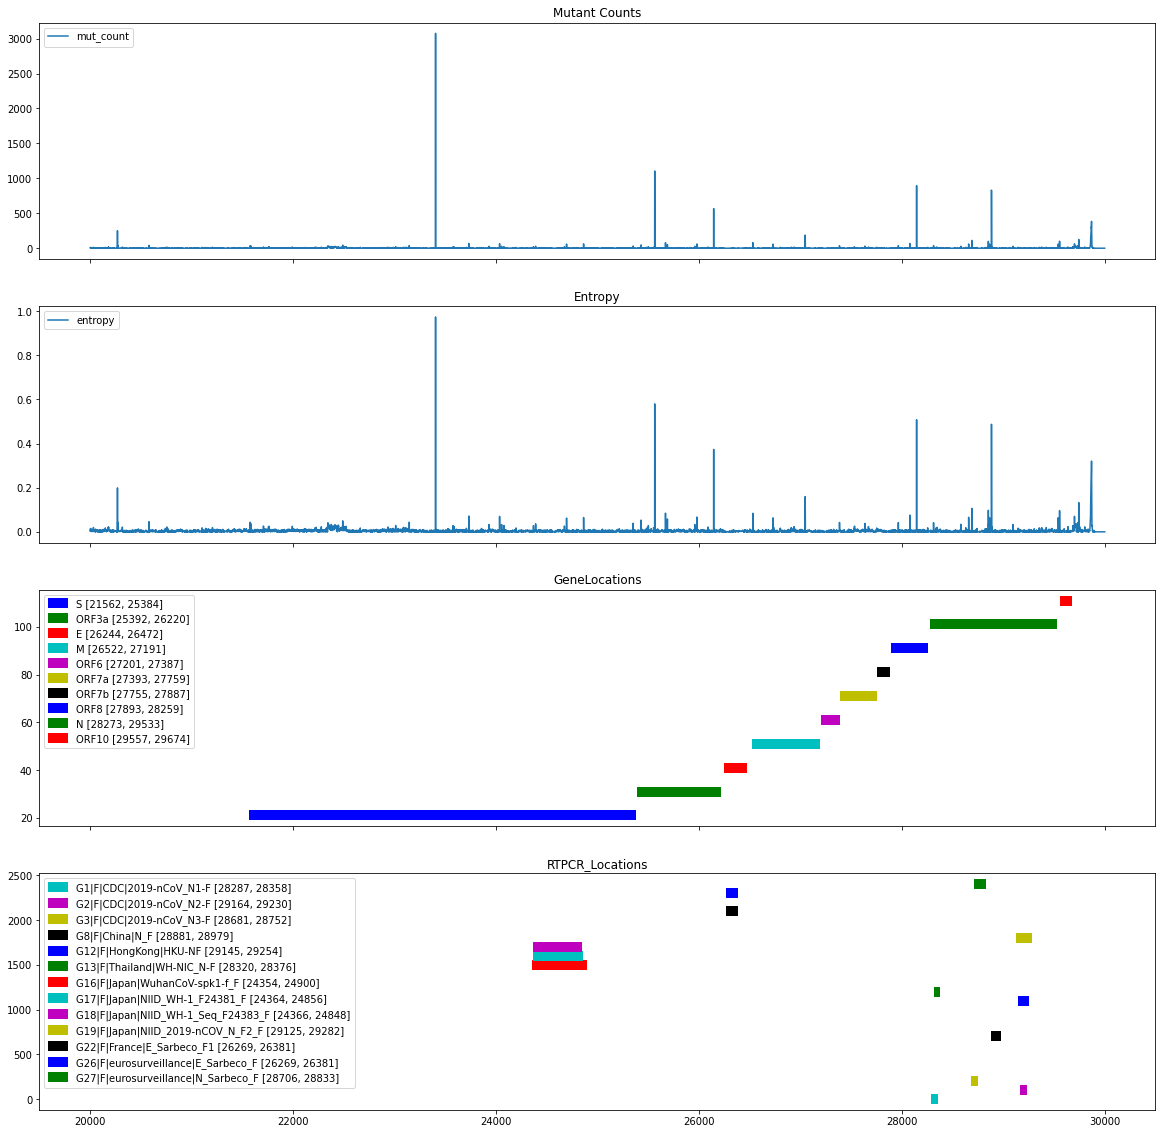

In [206]:
from matplotlib import pyplot as plt

start_idx, end_idx=(20000,30000)#(0,genome_sz)
colorsLst=['b', 'g', 'r', 'c', 'm', 'y', 'k']
LL=['idx', 'mut_count', 'entropy']
plotLst=np.array([range(start_idx, end_idx, 1), posLst[start_idx:end_idx], entropyLst[start_idx:end_idx]])
df=pd.DataFrame(plotLst.T, columns=LL)

MVwindow=50
rolling_mean = df.entropy.rolling(window=MVwindow).mean()*10
#rolling_mean2 = df.mut_count.rolling(window=10).mean()
#https://towardsdatascience.com/implementing-moving-averages-in-python-1ad28e636f9d

fig, axs = plt.subplots(4, figsize=(20,20), sharex=True)

axs[0].set_title('Mutant Counts')
axs[0].plot(df.idx, df.mut_count, label='mut_count')
axs[0].legend(loc='upper left')
#plt.plot(df.idx, rolling_mean2, label='mut_count 10', color='magenta')
axs[1].plot(df.idx, df.entropy, label='entropy')
#axs[1].plot(df.idx, rolling_mean, label='entropy MV%i'%MVwindow, color='orange')
axs[1].set_title('Entropy')
axs[1].legend(loc='upper left')

i=0
for gene, y, xmin, xmax in gene_plotLst:
    if not((start_idx<xmin<end_idx) or (start_idx<xmax<end_idx)):continue
    xmin=max(start_idx, xmin)
    xmax=min(end_idx, xmax)
    axs[2].hlines(y, xmin, xmax, colors=colorsLst[i%len(colorsLst)], linestyles='solid', label=gene, linewidth=10)
    i+=1
axs[2].set_title('GeneLocations')
axs[2].legend(loc='upper left')

for primer_set, y, xmin, xmax in rtpcrLst:
    if not((start_idx<xmin<end_idx) or (start_idx<xmax<end_idx)):continue
    xmin=max(start_idx, xmin)
    xmax=min(end_idx, xmax)
    axs[3].hlines(y, xmin, xmax, colors=colorsLst[i%len(colorsLst)], linestyles='solid', label=primer_set, linewidth=10)
    i+=1
axs[3].set_title('RTPCR_Locations')
axs[3].legend(loc='upper left')

plt.show()

#plt.plot(posLst)

In [209]:
#Extract Design Region
genomic_fn='coronarefseq_NC_045512.fa'
ofp=open(seq_ud+'covid_lamp_design_region.fa', 'w')
idx=0
for q_rec in SeqIO.parse(seq_ud+genomic_fn, "fasta"):
    print(idx, q_rec.id, end='\r')
    idx+=1

s,e=24000, 24500
label=q_rec.name.replace('\n', '').strip()+'|%i:%i'%(s,e)
seq=q_rec.seq.__str__().replace('-','').replace(' ','')[s:e]
ofp.write('>%s\n%s\n'%(label, seq))
ofp.close()

## Lamp Designer:
http://loopamp.eiken.co.jp/e/lamp/primer.html  

https://primerexplorer.jp/e/

In [160]:
entropy([1000,7000]), entropy([3000, 5000]), entropy([4000, 4000]), entropy([2000, 2000, 2000, 2000]), entropy([200, 200, 200, 7400])

(0.5435644431995964, 0.9544340029249649, 1.0, 2.0, 0.5031837316805837)

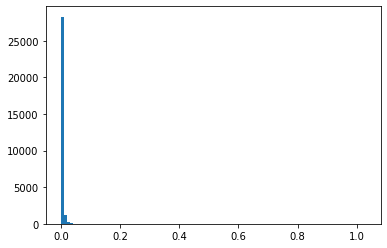

In [173]:
pp=plt.hist(df.entropy, bins=100)

## Compute Similarity for collected CoV

In [ ]:
colected_corona_path=seq_ud+'collected_corona_viruses.fa'
bo_path=seq_ud+'bo_collected_corona.txt'
#runBlast(colected_corona_path, seq_ud,  bo_path=bo_path, subj_pth, fdb_path=fdb_path)
oLst=[]
hitLst=[]
for bo_json in iter_blast_out_json(bo_path):
    report=bo_json["report"]
    query_label=report['results']["search"]["query_title"]
    query_len=report['results']["search"]["query_len"]
    query_similarity=-1
    if report['results']["search"]["hits"]:
        hit = report['results']["search"]["hits"][0]
        hit['query_len']=query_len
        hit_obj=Hit(hit)
        query_similarity=hit_obj.query_similarity
        hitLst.append(hit_obj)
    oLst.append([query_label, len(hit_obj.hspLst), query_len, query_similarity])

df=pd.DataFrame(oLst, columns=['query_label', 'num_hsp', 'query_len', 'query_similarity'])
df.to_csv(ud+'collected_corv.csv')

In [ ]:
hitLst[27].display()

In [ ]:
fpth=ud+'errorlogs.txt'
b=open(fpth, 'r').read()
l=b.split('COUNT: ')
l=[x[2:] for x in l]
df=pd.DataFrame(l, columns=['x'])
df.to_csv(ud+'errorlogs.csv')

## Deprecation Line

In [ ]:
#seq by seq blast and parse

mut_dict={};i=0
for q_rec in SeqIO.parse(seq_ud+gisaid_fn, "fasta"):
    print(i, len(mut_dict), q_rec.id, end='\r')
    SeqIO.write(q_rec, query_pth, "fasta")
    d=run_parse_blast(seq_ud, fdb_path, query_pth)
    mut_dict.update(d)
    i+=1
mut_dict